# Постановка задачи

![](https://obraz-asino.ru/media/moderator/Archive2015/50/c4et4ik.jpg)

В энергосбытовой компании (далее - ЭСК) есть несознательные абоненты, которые имеют просроченную задолженность за потребленную электроэнергию. С этими должниками проводится некоторая работа. По результатам работы от должников поступает оплата. Каждый день в ЭСК через банки, почтовые переводы, онлайн-сервисы и кассы компании регистрируются деньги от абонентов, в том числе и от должников. Необходимо предсказать, каковы будут оплаты от должников в ближайший год в целом по всем подразделениям ЭСК, расположенных в разных регионах РФ.    
     
Для предсказания из рабочей базы данных ЭСК получена информация о ежедневнем поступлении платежей от абонентов, числившихся в момент оплаты должниками с просрочкой долга. Абоненты, чьи неоплаченные счета ещё не были признаны просроченными, в выборку для предсказания не включались. Выборка представляет из себя временной ряд с шагом в 1 день.    
     
Выборка содержит суммы высокого порядка (сотни тысяч и миллионы рублей), поскольку информация составлена суммарно по нескольким регионам РФ. Суммы большие еще и по той причине, что должниками признаются абоненты, у которых просрочка оплаты составляет 2 месяца и более, объемом в 2 норматива потребления и более. Столь низкий порог для признания абонента должником помещает не менее четверти всех абонентов в разряд должников.
    
Предсказание оплаты долга позволит ЭСК корректнее планировать бюджет и расходы.

**Предупреждение:** данные в процессе сбора были изменены на некоторый коэффициент. Поэтому приводимые здесь суммы не могут раскрывать коммерческую тайну о финансовом положении ЭСК.

# Библиотеки и функции

In [1]:
import numpy as np 
from numpy import array
import pandas as pd 
from datetime import datetime, date, timedelta 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm 
import math as m
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
                   
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import keras
from keras.layers import Dense, Input, LSTM, Dropout, Activation, SimpleRNN
from keras.layers import Bidirectional, Flatten, RepeatVector
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential
from keras.models import load_model

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

from fbprophet import Prophet
import holidays
import json
from fbprophet.serialize import model_to_json, model_from_json
import pickle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/payments/pay.csv
/kaggle/input/payments-model/bi_lstm.hdf5
/kaggle/input/payments-model/results_seasonal.pickle
/kaggle/input/payments-model/prophet.pickle
/kaggle/input/payments-model/sr1.hdf5
/kaggle/input/payments-model/rnn.hdf5
/kaggle/input/payments-model/lstm.hdf5
/kaggle/input/payments-model/conv1.hdf5
/kaggle/input/payments-model/conv2.hdf5
/kaggle/input/payments-model/result_trend.pickle
/kaggle/input/payments-model/sr2.hdf5


In [2]:
# Глобальные константы
START_DATE = "2020-01-31" # Дата отсечки тренировочных данных от тестовых
PRED_LEN = 446            # Длина тестовых данных
PRED_COLUMN = "PAY"       # Имя признака во временном ряду
INPUT_LEN = 30            # Длина скользящего окна (месяц)

In [4]:
# Mean absolute percentage_error
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
# Функция для построения графика истинного ряда и его предсказания
def plot_prediction(df, prediction): 
    plt.figure(figsize=(25, 12))
    plt.plot(df.index[df.index>=START_DATE], prediction, label="prediction", alpha=.7)
    plt.plot(df.index[df.index>=START_DATE], df.loc[df.index>=START_DATE, PRED_COLUMN], label="real", alpha=.7)
    plt.scatter(df.index[df.index>=START_DATE], prediction, label="prediction", alpha=.7)
    plt.scatter(df.index[df.index>=START_DATE], df.loc[df.index>=START_DATE, PRED_COLUMN], label="real", alpha=.7)
    plt.legend()
    plt.title(PRED_COLUMN + " Prediction")
    plt.show()

# Чтение, преобразование и анализ данных

### Данные временного ряда

In [6]:
# Читаем данные по оплатам должников, выгруженные из рабочей БД
df = pd.read_csv('../input/payments/pay.csv', sep=';')

# Смотрим на данные
display(df.head(5))
display(df.tail(5))

PAY   CNT    PAY_DATE
0    1    27414,73    29  01.01.2008
1    2  2449479,03  4316  02.01.2008
2    3  1534554,04  2462  03.01.2008
3    4   2696278,4  4997  04.01.2008
4    5  1389097,57  2784  05.01.2008

PAY     CNT    PAY_DATE
4856  4857   45653939,69   57379  18.04.2021
4857  4858  119279353,55  170618  19.04.2021
4858  4859   78485233,63  114595  20.04.2021
4859  4860      29119,06       1  27.05.2021
4860  4861         99,44       2  27.07.2021

**Пояснение по столбцам:**    
Первый столбец без имени - порядковый номер строки. Столбец создан автоматически при экспорте данных в файл.    
PAY - сумма оплат по задолженностям, поступившая в текущий день     
CNT - количество оплат по задолженностям, поступившее в текущий день    
PAY_DATE - текущий день оплаты

In [7]:
# Последние 2 строки явно выбиваются из общего ряда. Удалим их из датасета
df = df.iloc[:-2]

In [8]:
# Информация о наборе данных
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859 entries, 0 to 4858
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0             4859 non-null   int64 
 1   PAY       4859 non-null   object
 2   CNT       4859 non-null   int64 
 3   PAY_DATE  4859 non-null   object
dtypes: int64(2), object(2)
memory usage: 152.0+ KB


None

In [9]:
# Столбец PAY имеет строковый вид. Преобразуем его в число
df['PAY'] = df['PAY'].apply(lambda x: float(x.replace(',','.')))

In [10]:
# Проверим статистики числовых столбцов
display(df.describe())

PAY            CNT
count  4859.000000  4.859000e+03    4859.000000
mean   2430.000000  3.723352e+07   54429.633052
std    1402.816809  2.636295e+07   40451.726343
min       1.000000  2.741473e+04      29.000000
25%    1215.500000  1.902067e+07   26610.500000
50%    2430.000000  3.035343e+07   41501.000000
75%    3644.500000  5.281596e+07   77513.000000
max    4859.000000  1.520296e+08  202837.000000

Предметом анализа будет являться только признак PAY. Безымянный столбец и столбец с количеством удалим, а столбец с оплатой разделим на 1000, чтобы оперировать меньшими суммами.    
Строковые даты превратим в истинные даты и столбец с ними сделаем индексом.

In [11]:
# Переходим к тысячам рублей
df['PAY'] = df['PAY']/1000

# Строковый столбец с датой оплаты преобразуем к дате и сортируем по дате
df['Date'] = pd.to_datetime(df['PAY_DATE'], format = '%d.%m.%Y')
df = df.sort_values(by='Date')

# Превращаем дату в индекс
df = df.set_index(pd.DatetimeIndex(df['Date']))

# Удаляем ненужные столбцы
df = df.drop(df.columns[0], axis=1)
df = df.drop(['Date', 'PAY_DATE', 'CNT'], axis =1)
df

PAY
Date                    
2008-01-01      27.41473
2008-01-02    2449.47903
2008-01-03    1534.55404
2008-01-04    2696.27840
2008-01-05    1389.09757
...                  ...
2021-04-16   95706.61017
2021-04-17   67019.09646
2021-04-18   45653.93969
2021-04-19  119279.35355
2021-04-20   78485.23363

[4859 rows x 1 columns]

In [12]:
# Проверим, есть ли пропуски в датах
print(len(df.index))
print((df.index[-1]-df.index[0]).days + 1)

4859
4859


Пропусков по дням нет. Интерполяция данных не требуется.

In [13]:
# Оформим в функцию чтение и обработку датасета
def get_data():
    df = pd.read_csv('../input/payments/pay.csv', sep=';')
    df = df.iloc[:-2]
    df['PAY'] = df['PAY'].apply(lambda x: float(x.replace(',','.')))
    df['PAY'] = df['PAY']/1000
    df['Date'] = pd.to_datetime(df['PAY_DATE'], format = '%d.%m.%Y')
    df = df.sort_values(by='Date')
    df = df.set_index(pd.DatetimeIndex(df['Date']))
    df = df.drop(df.columns[0], axis=1)
    df = df.drop(['Date', 'PAY_DATE', 'CNT'], axis =1)
    
    return df

In [15]:
# Сохраним последний индекс набора данных для отсечки реальных и спрогнозированных данных
LAST_REAL = df.index[-1]
LAST_REAL

Timestamp('2021-04-20 00:00:00')

### Визуализация временного ряда

In [16]:
# Построим график зависимости сумм оплат от времени
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df.PAY, mode='lines'))
fig.show() 

По графику видно, что выделяются пики оплат и что оплаты носят колебательный (сезонный характер). При этом пик оплат до 2014 года приходился на декабрь, а начиная с 2014 - на февраль.Скорее всего, это связано с тем, до 2013 года расчет за декабрь и премии выплачивались до наступления нового года, а начиная с 2014 года и с учетом кризиса в экономике - после новогодних каникул.    
Также видно, что амплитуда колебаний растёт. связано это с тем, что тарифы на электроэнергию с годами росли, соответственно, росли и оплаты.     
     
Для наглядности построим укрупненный график за 2 года, год, полгода, месяц.

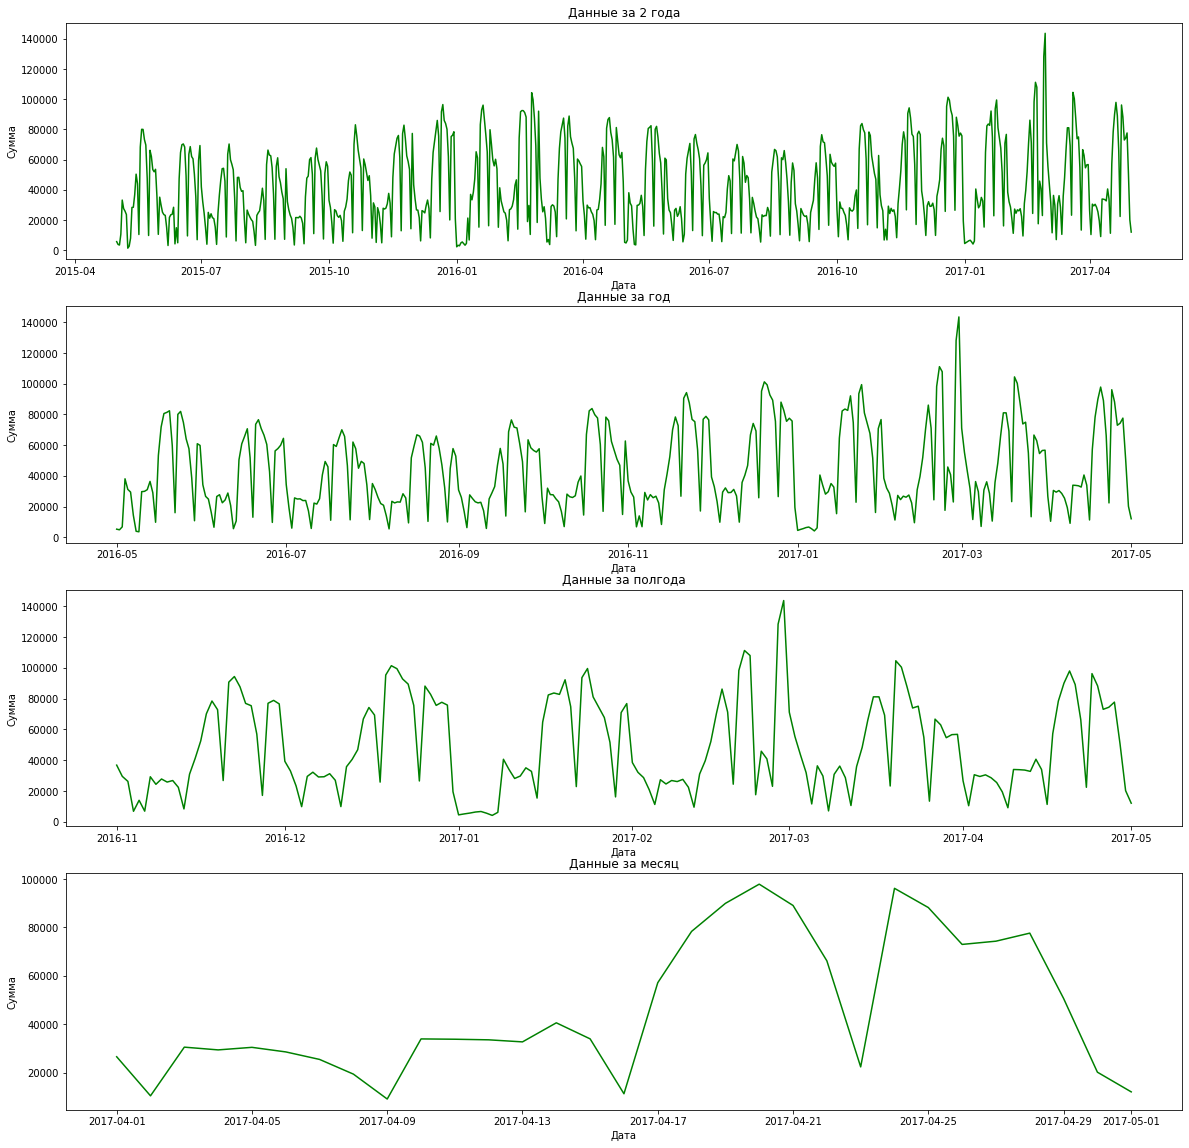

In [17]:
# Укрупненные выборочные графики оплат
f, ax = plt.subplots(4, 1, figsize=(20, 20))
ax[0].plot(df.PAY[(df.index >= '2015-05-01') & (df.index <= '2017-05-01')], c='g')
ax[0].set_title('Данные за 2 года')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Сумма')

ax[1].plot(df.PAY[(df.index >= '2016-05-01') & (df.index <= '2017-05-01')], c='g')
ax[1].set_title('Данные за год')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Сумма')

ax[2].plot(df.PAY[(df.index >= '2016-11-01') & (df.index <= '2017-05-01')], c='g')
ax[2].set_title('Данные за полгода')
ax[2].set_xlabel('Дата')
ax[2].set_ylabel('Сумма')

ax[3].plot(df.PAY[(df.index >= '2017-04-01') & (df.index <= '2017-05-01')], c='g')
ax[3].set_title('Данные за месяц')
ax[3].set_xlabel('Дата')
ax[3].set_ylabel('Сумма')

plt.show()

Колебания в оплатах идут:    
* по годам,
* по месяцам в году,
* по неделям в месяцах,
* по дням в неделях.

<AxesSubplot:>

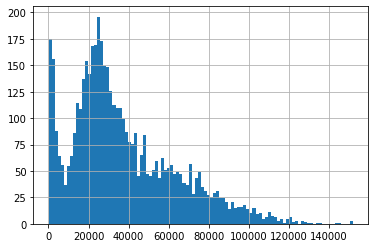

In [18]:
# Проверим распределение исследуемой величины
df.PAY.hist(bins=100)

Распределение величины - сумма двух почти нормальных распределений. Если удалить из рассмотрения все оплаты  суммой < примерно 6000, то модели классического ML при генерации новых дополнительных признаков могли бы показать неплохие результаты. Но таких платежей достаточно много, поэтому удалять ничего не будем.

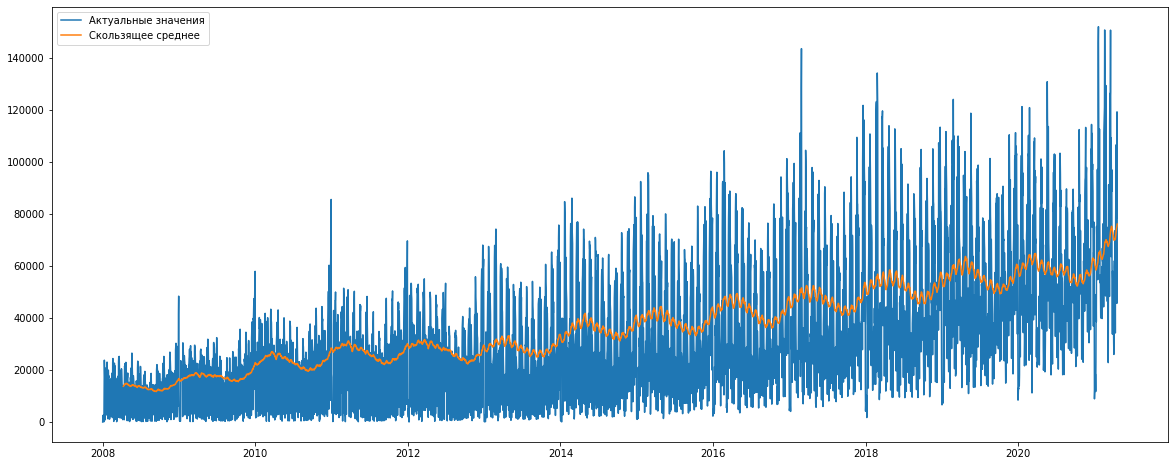

In [19]:
# Визуализируем скользящее среднее
roll_mean = df.PAY.rolling(window = 100).mean()
plt.figure(figsize=(20,8))
plt.plot(df.PAY,label="Актуальные значения")
plt.plot(roll_mean,label="Скользящее среднее")
plt.legend(loc="upper left")
plt.show()

График показывает, что сезонные колебания - годовые и месячные - есть даже у сглаженного ряда, составленного из скользящих средних.    
      
Проверим сезонность и тренд, разложив временной ряд на составляющие. Сезонную декомпозицию проверим в двух вариантах - мультипликативном и аддитивном. Для исследуемого ряда более подходит мультипликативное разложение, так как со временем увеличиваются не только средние значения, но и амплитуды колебаний. Тем не менеее, проверим оба варианта.

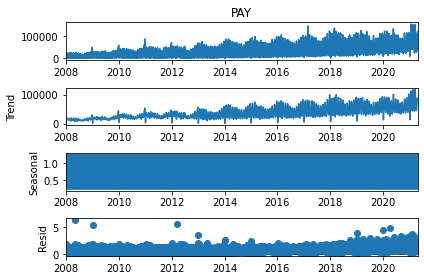

In [21]:
# Применяем разложение на тренд, сезонность и остаток для мультипликативной модели 
#    (временной ряд = произведению трех частей)
decomposition = seasonal_decompose(df.PAY, model='multiplicative')
decomposition.plot()
plt.show()

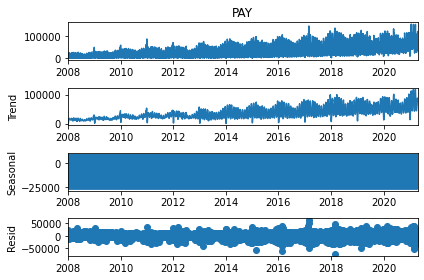

In [22]:
# Применяем разложение на тренд, сезонность и остаток для аддитивной модели 
#    (временной ряд = сумме трех частей)
decomposition = seasonal_decompose(df.PAY, model='additive')
decomposition.plot()
plt.show() 

Трендовая и сезонная части выглядят примерно одинаково, но остаточная часть при мультипликативном варианте имеет несколько обособленных выбросов. Аддитивная модель выглядит компактнее и предпочтительнее для раздельного предсказания каждой части.   
Сезонная составляющая имеет слишком малый период и поэтому не позволяет рассмотреть ее на столь малом размере графика.

In [23]:
# Выделим отдельные составляющие для более детального рассмотрения
trend_part = decomposition.trend       # трендовая составляющаяя
seasonal_part = decomposition.seasonal # сезонная составляющаяя
residual_part = decomposition.resid    # шум

In [24]:
# Удаляем пустые значения
trend_part = trend_part[~trend_part.isnull()]
seasonal_part = seasonal_part[~seasonal_part.isnull()]
residual_part = residual_part[~residual_part.isnull()]

# Проверяем длины рядов
print()
print('Полный ряд: %d' % len(df))
print('Тренд: %d' % len(trend_part))
print('Сезонность: %d' % len(seasonal_part))
print('Шум: %d' % len(residual_part))


Полный ряд: 4859
Тренд: 4853
Сезонность: 4859
Шум: 4853


Text(0.5, 1.0, 'Остаток')

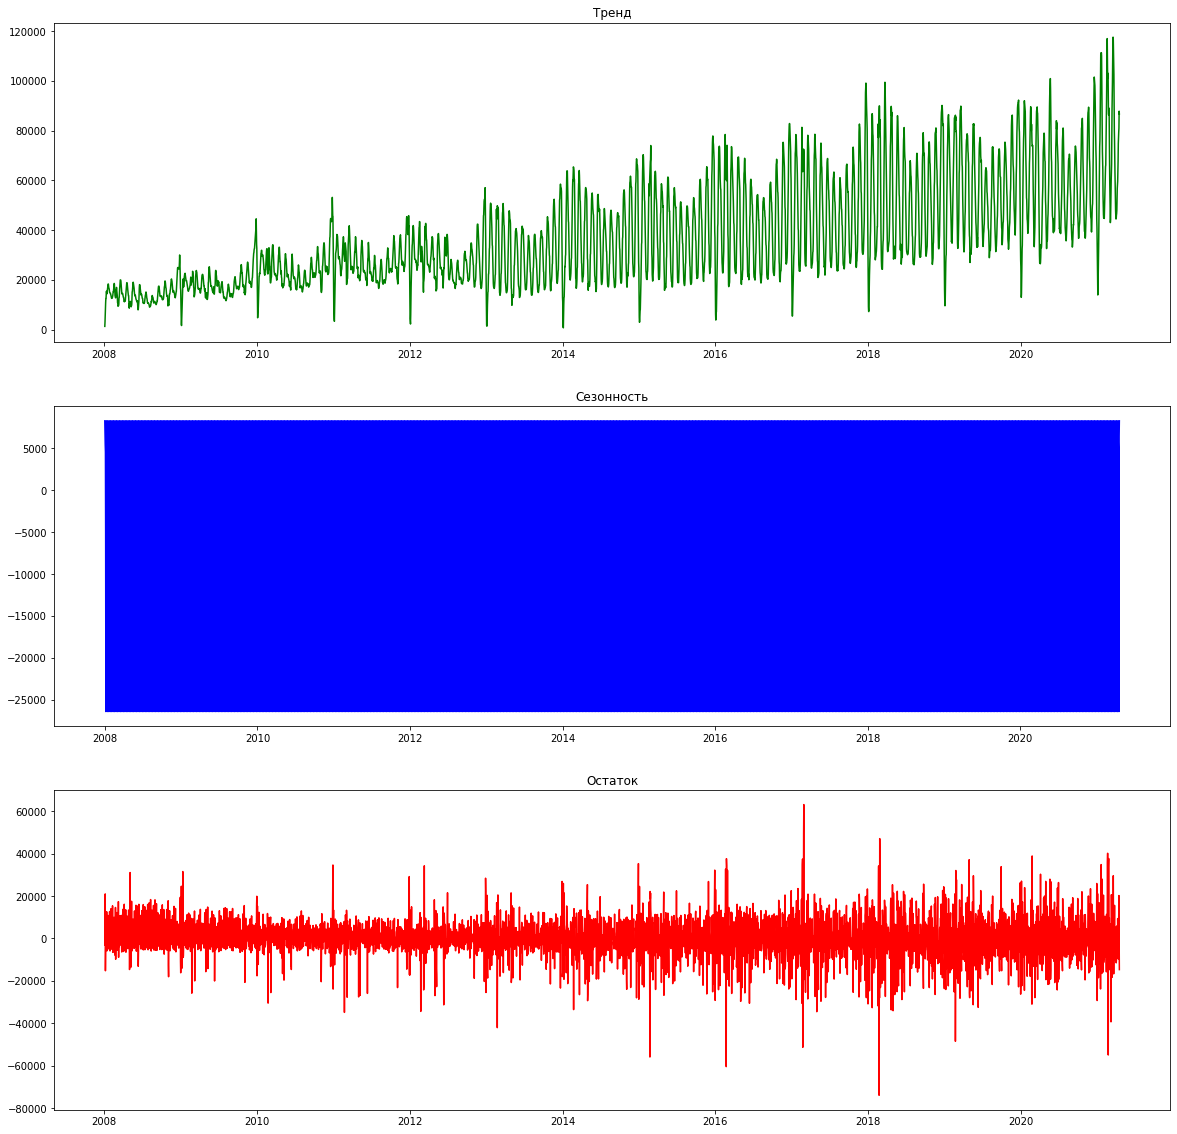

In [25]:
# Графики составляющих декомпозиции ряда
f, ax = plt.subplots(3, 1, figsize=(20, 20))
ax[0].plot(trend_part, c='g')
ax[0].set_title('Тренд')
ax[1].plot(seasonal_part, c='b')
ax[1].set_title('Сезонность')
ax[2].plot(residual_part, c='r')
ax[2].set_title('Остаток')

Ряд достаточно сложный: и трендовая часть, и остаточная содержат сезонные компоненты, вследствие чего совершают колебания. Это означает, что применение классического метода ARIMA покажет некачественный результат предсказания и лучше применять вариант ARIMA, дополненный учетом сезонных колебаний - SARIMAX.   
     
Ввиду того, что тренд и остаток цикличны, можно попробовать их так же разложить на отдельные компоненты.

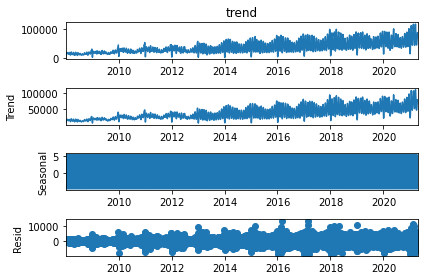

In [26]:
# Применяем разложение на тренд, сезонность и остаток для трендовой части главного ряда
decomposition_trend = seasonal_decompose(trend_part, model='additive')
decomposition_trend.plot()
plt.show()

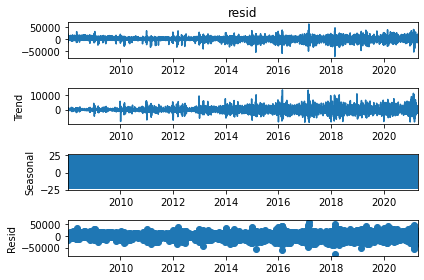

In [27]:
# Применяем разложение на тренд, сезонность и остаток для остаточной части главного ряда
decomposition_res = seasonal_decompose(residual_part, model='additive')
decomposition_res.plot()
plt.show()

Долгие эксперименты показали, что в итоге наш главный ряд является фрактальным. Любое сколь угодно глубокое разложение отдельных его составляющих и отдельных частей этих составляющих не убирает сезонные колебания и сохраняет виды колебаний практически в неизменном виде.    
По этой причине вместо классического ML далее упор будет делаться на глубокое обучение.

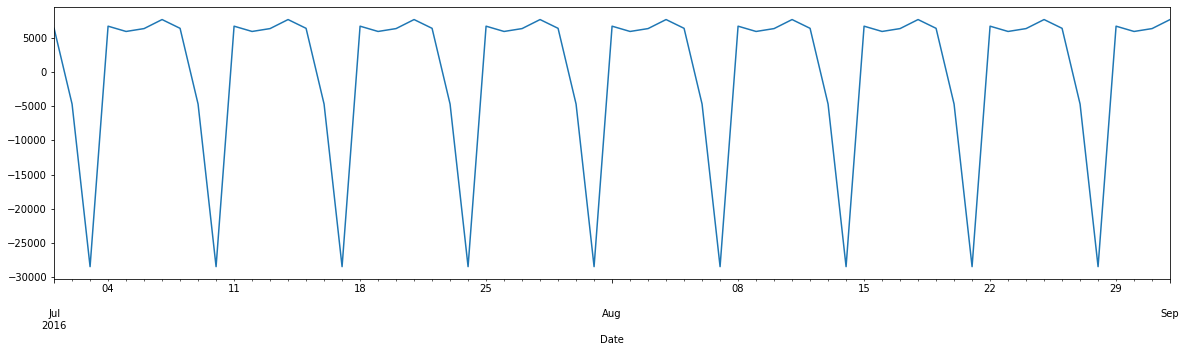

In [28]:
# Сезонность колеблется слишком часто. Разглядим ее подробнее на малом отрезке времени
plt.figure(figsize=(20,5))
dfsea = df[(df.index>="2016-07-01") & (df.index<="2016-09-01")]
seasonal=seasonal_decompose(dfsea[['PAY']]).seasonal
seasonal.plot()
plt.show()

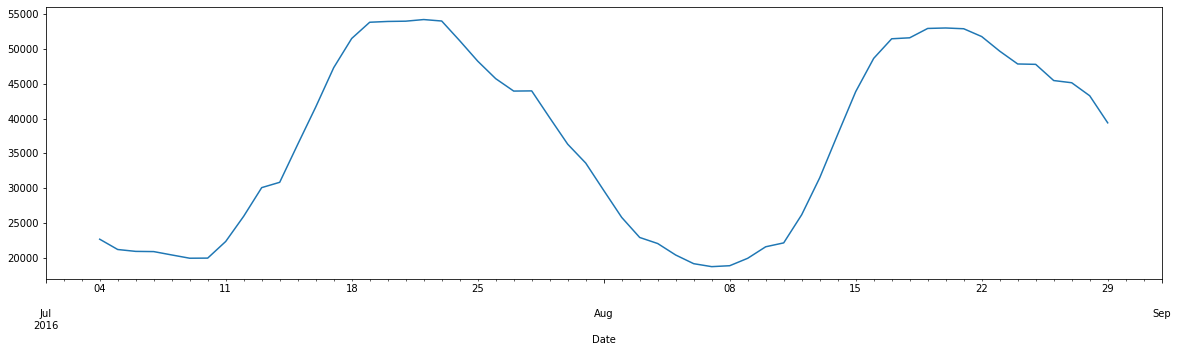

In [29]:
# Ещё подробнее
plt.figure(figsize=(20,5))
dfsea = df[(df.index>="2016-07-01") & (df.index<="2016-09-01")]
trend=seasonal_decompose(dfsea[['PAY']]).trend
trend.plot()
plt.show()

В сезонности отчетливо просматриваются недельные отрезки с выходными днями. По выходным оплаты проводится мало. 

Проверим стационарность главного ряда и тренда.

In [30]:
# Тест Дикки-Фуллера
adf = sm.tsa.adfuller(df.PAY) 
p_value = adf[1]
print ('p-value: ', p_value)
if p_value > 0.05: 
    print('Главный ряд не стационарен.')
else:
    print('Главный ряд стационарен.')
    
print()

adf = sm.tsa.adfuller(trend_part) 
p_value = adf[1]
print ('p-value: ', p_value)
if p_value > 0.05: 
    print('Ряд тренда не стационарен.')
else:
    print('Ряд тренда стационарен.')

p-value:  0.4450708323814963
Главный ряд не стационарен.

p-value:  0.5409892549679702
Ряд тренда не стационарен.


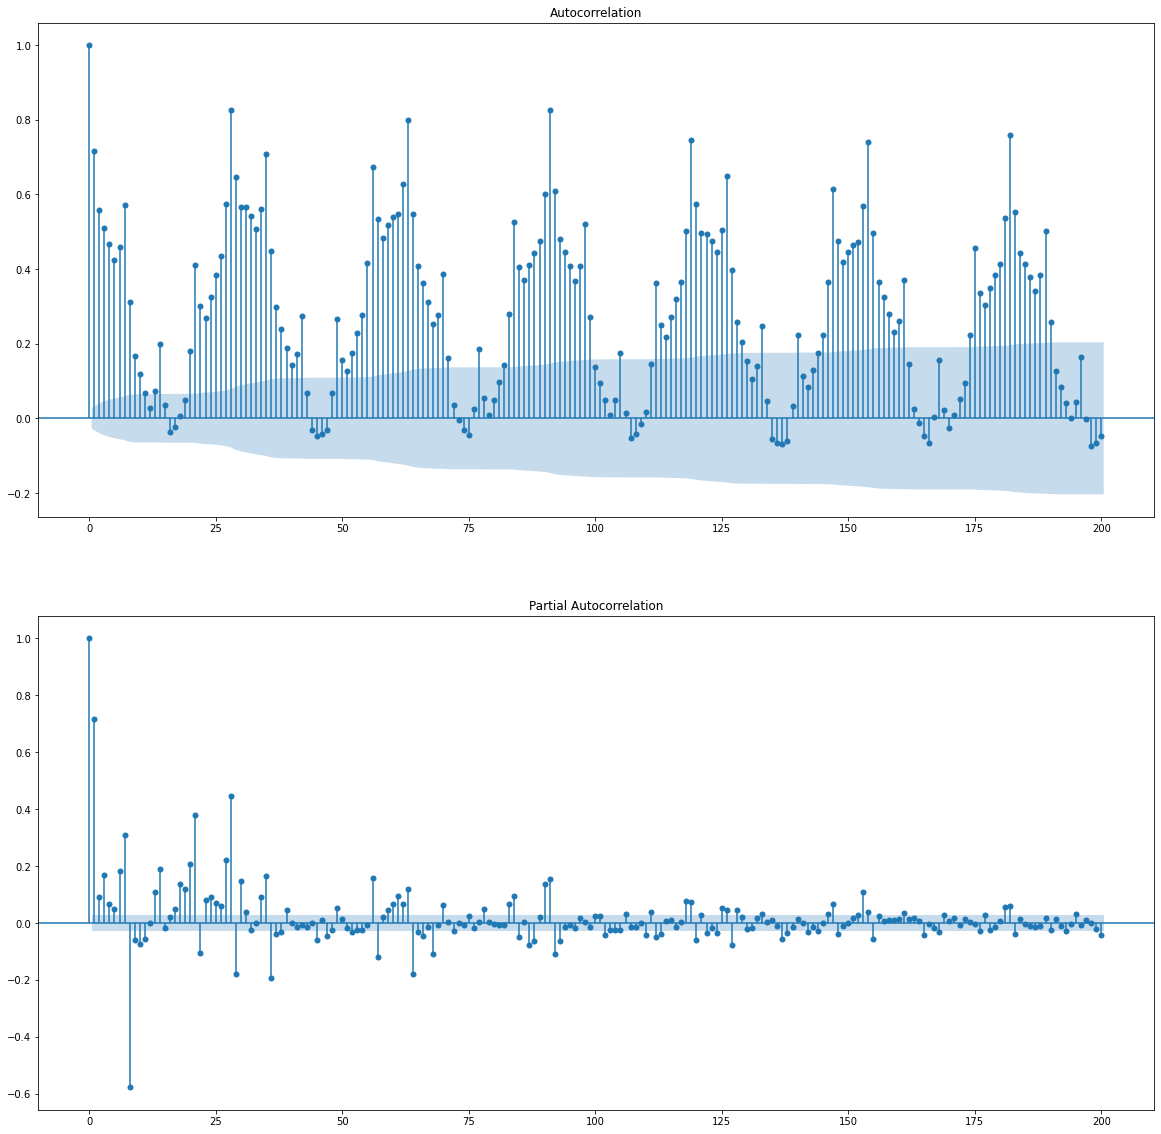

In [32]:
# Визуализируем автокорреляцию и частичную автокорреляцию ряда
f, ax = plt.subplots(2, 1, figsize=(20, 20))
sm.graphics.tsa.plot_acf(df.PAY.squeeze(), lags=200, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.PAY.squeeze(), lags=200, ax=ax[1])
plt.show()

Графики автокорреляции показывают явную сезонность и, следовательно, нестационарность ряда. Дифференцирование ряда не улучшило ситуацию. Был проведен эксперимент с дифференцированием 100 раз, но периодичность автокорреляции осталась, и в доверительный интервал 0.05 автокорреляция дифференцированного ряда так и не попала.

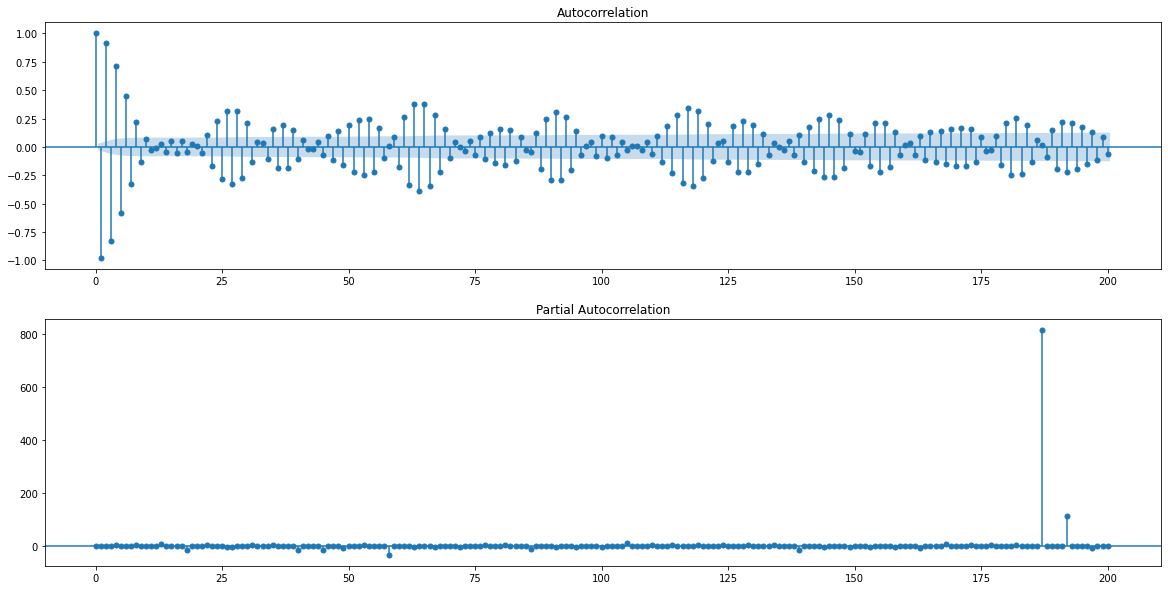

Критерий Дики-Фуллера: p=0.000000


In [33]:
# Эксперимент: дифференцирование ряда 100 раз
i = 1
pay_d = df.PAY
while i<101:
    pay_d = pay_d.diff().iloc[1:]
    i += 1

f, ax = plt.subplots(2, 1, figsize=(20, 10))
sm.graphics.tsa.plot_acf(pay_d.squeeze(), lags=200, ax=ax[0])
sm.graphics.tsa.plot_pacf(pay_d.squeeze(), lags=200, ax=ax[1])
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(pay_d)[1])

Ряд фрактальный и предсказания для него лучше строить при помощи нейронных сетей.

# Предсказание методом SARIMAX

Для предсказания будем использовать SARIMAX, который умеет учитывать сезонность.   
Параметры p, d, q по графику автокорреляции не определяются, так как не обнаружен "хвост", попадающий в доверительный интервал. Опытным путем были подобраны параметры, которые дают более или менее подходящую точность. Последний параметр "s" установлен = 12, так как глобальный период сезонности = 12 месяцев.     
   
Нормализация данных здесь не использовалась, хотя проверка модели на нормализованных и даже прологарифмированных данных тоже проводилась. Логарифмирование существенно ухудшало метрику, а нормализация вообще на неё не влияла.    
      
Метрика при параметре p = 10 получалась самая низкая из всех опробованных: mape = 40.01

In [34]:
# Строим модель, обучаем и предсказываем
arima = sm.tsa.statespace.SARIMAX(df.PAY[df.index<START_DATE],
                                order=(0, 0, 1),
                                seasonal_order=(4, 1, 1, 12), # 10 - лучше. Метрика = 40
                                enforce_stationarity=False,
                                enforce_invertibility=False)
arima_result = arima.fit()
arima_pred = arima_result.predict(start = PRED_LEN, end = len(df)-1, typ="levels").rename("SARIMAX Predictions")

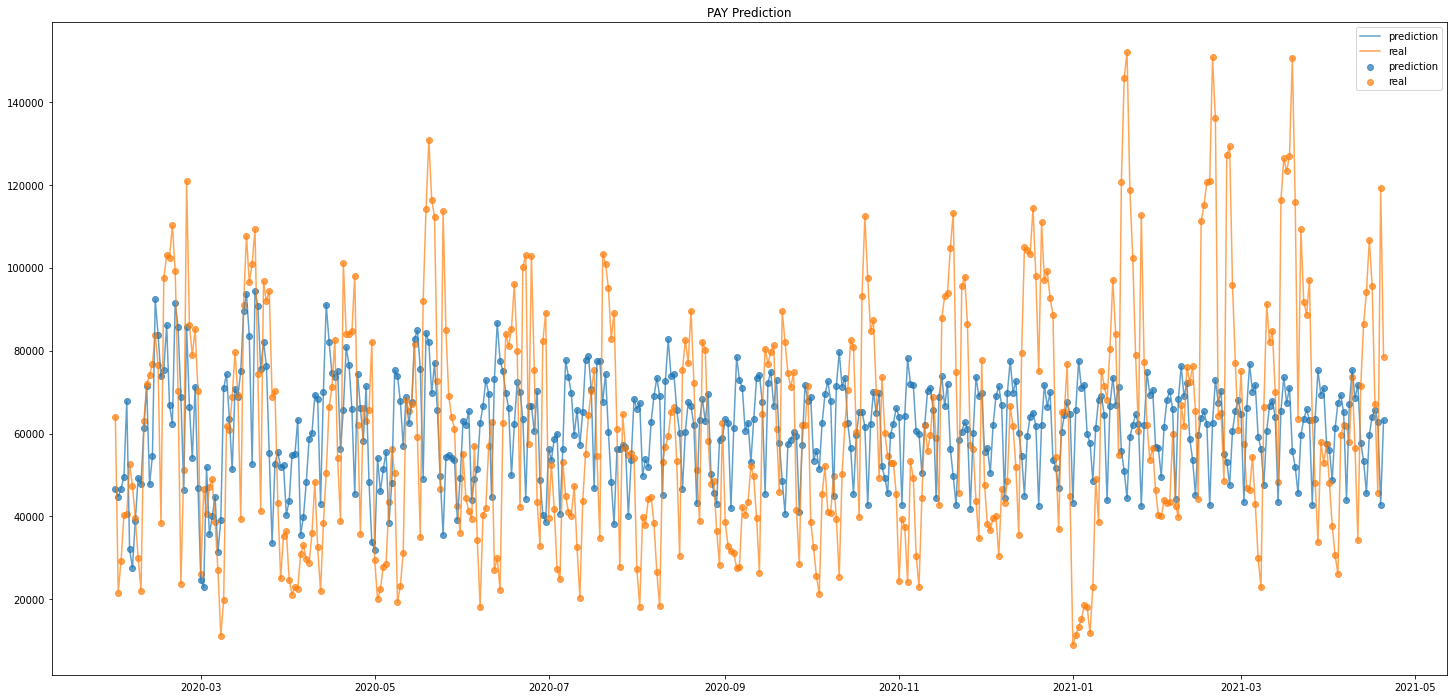

51.82870706175494

In [35]:
# Сравниваем графики тестовых истинных значений и предсказания
plot_prediction(df, arima_pred[arima_pred.index>=START_DATE])

# Проверяем метрику
mape(df[df.index>=START_DATE].PAY, arima_pred[arima_pred.index>=START_DATE])

mape = 51.83

Метрика **mape** выбрана по той причине, что она показывает относительную ошибку. Прочие метрики показывают абсолютные значения, что выдает большие значения из-за больших сумм ряда.

Попробуем получить отдельные предсказания для составлящих декомпозированного ряда и затем сложить их.

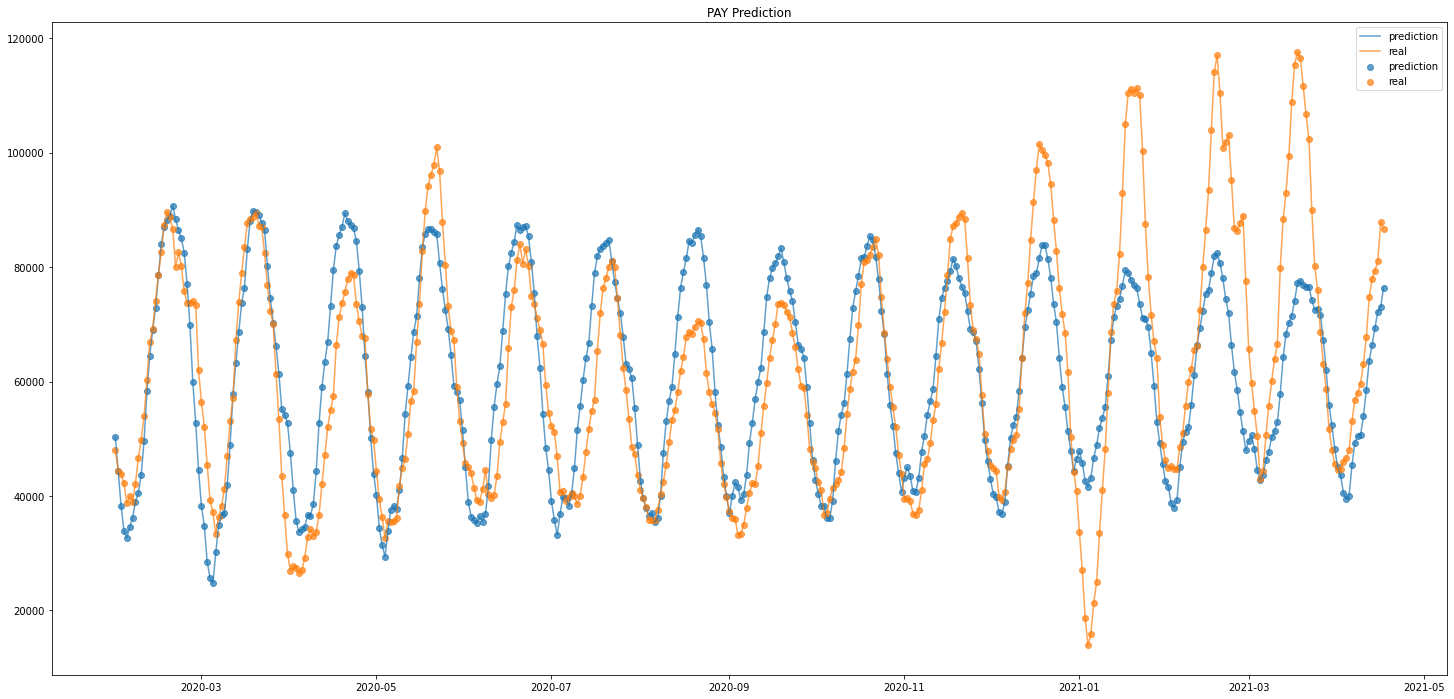

15.560797491117922

In [36]:
# Предсказываем для тренда
arima_trend = sm.tsa.statespace.SARIMAX(trend_part[trend_part.index<START_DATE],
                                order=(0, 0, 1),
                                seasonal_order=(4, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

result_trend = arima_trend.fit()
arima_pred_trend = result_trend.predict(start = PRED_LEN, end = len(df)-1, typ="levels").rename("PAY")

maxIndex = trend_part.index.max()
plot_prediction(trend_part.to_frame(name='PAY'), 
                arima_pred_trend[(arima_pred_trend.index>=START_DATE) & (arima_pred_trend.index<=maxIndex)])


mape(trend_part[trend_part.index>=START_DATE].values, 
     arima_pred_trend[(arima_pred_trend.index>=START_DATE) & (arima_pred_trend.index<=maxIndex)])

mape для тренда = 15.56

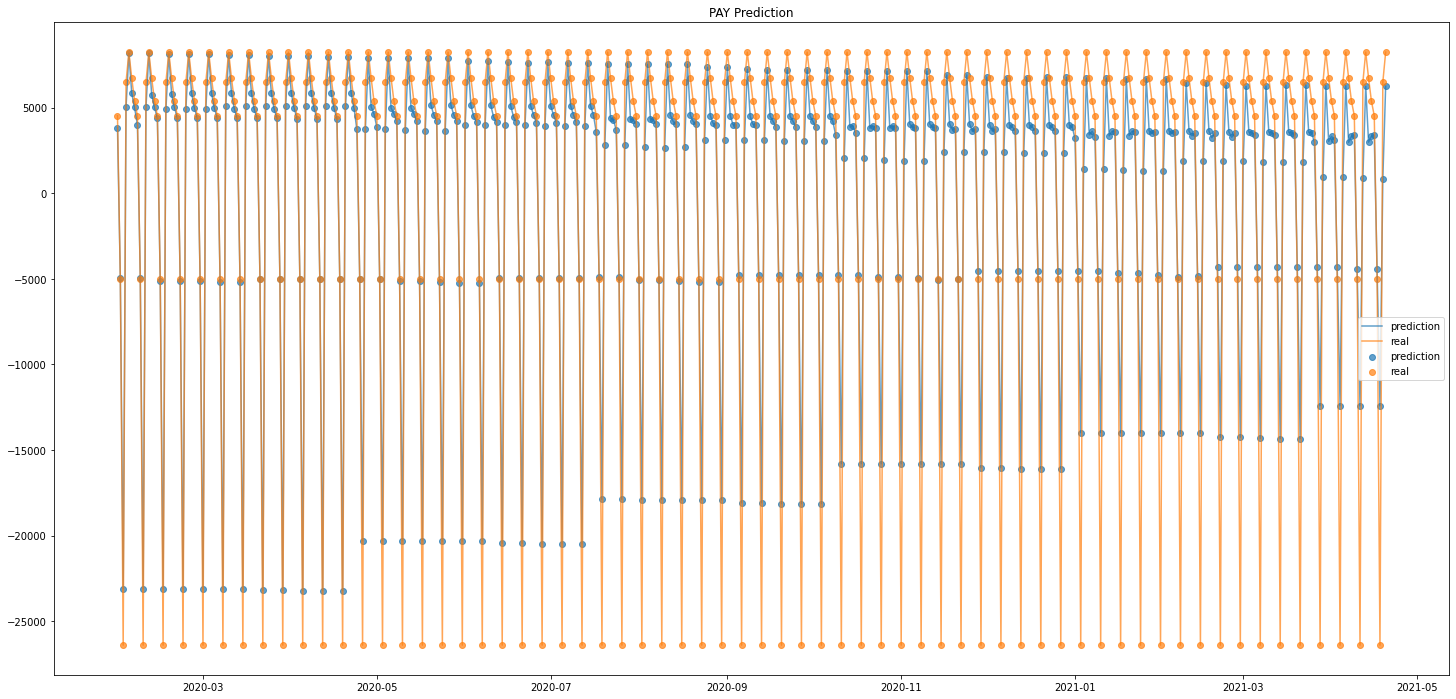

24.66496843977551

In [37]:
# Предсказание для сезонности
arima_seasonal = sm.tsa.statespace.SARIMAX(seasonal_part[seasonal_part.index<START_DATE],
                                order=(0, 0, 1),
                                seasonal_order=(6, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results_seasonal = arima_seasonal.fit()
arima_pred_seasonal = results_seasonal.predict(start = PRED_LEN, end = len(df)-1, typ="levels")

plot_prediction(seasonal_part.to_frame(name='PAY'), arima_pred_seasonal[arima_pred_seasonal.index>=START_DATE])
mape(seasonal_part[seasonal_part.index>=START_DATE].values, arima_pred_seasonal[arima_pred_seasonal.index>=START_DATE])

mape для сезонности = 24.35

Сезонность можно не предсказывать, так как она для всех лет остается неизменной.

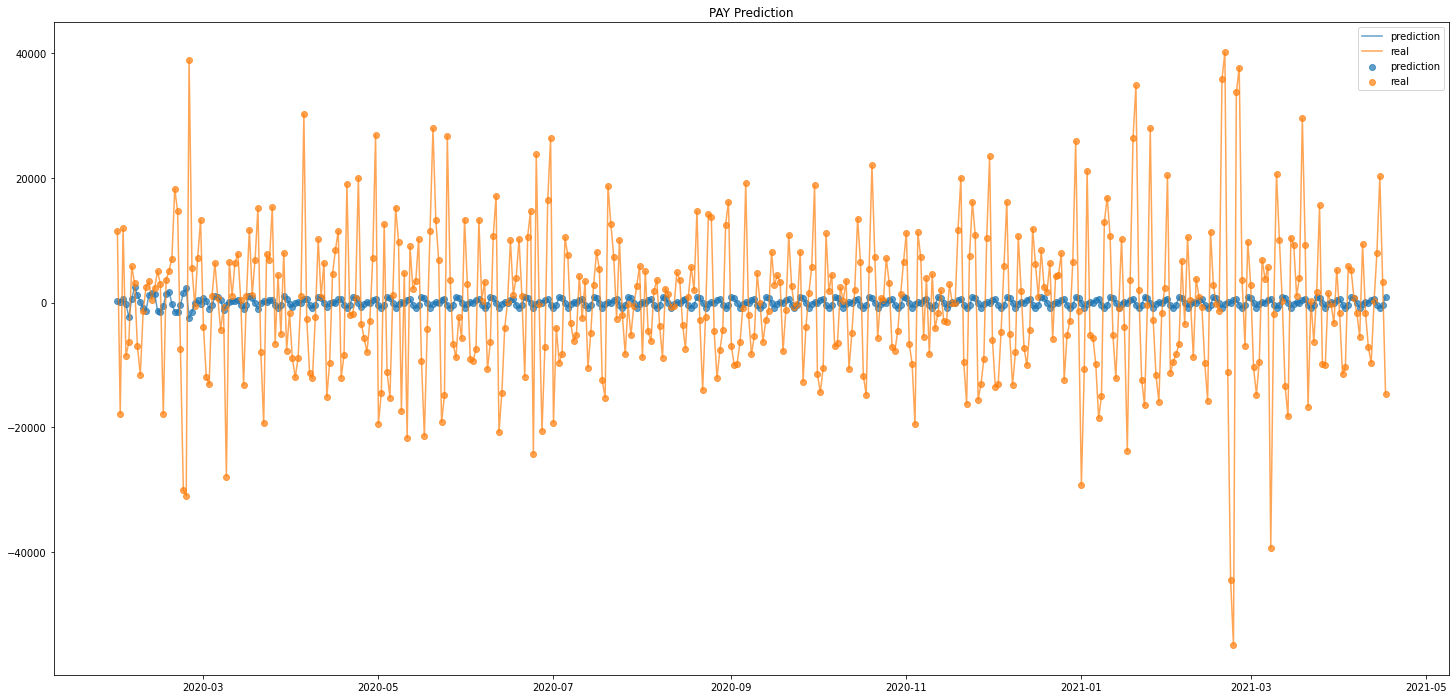

105.32163811842807

In [38]:
# Предсказание для шума (который тоже, на самом деле, имеет закономерности)
arima_residual = sm.tsa.statespace.SARIMAX(residual_part[residual_part.index<START_DATE],
                                order=(0, 0, 1),
                                seasonal_order=(4, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results_residual = arima_residual.fit()
arima_pred_residual = results_residual.predict(start = PRED_LEN, end = len(df)-1, typ="levels")

maxIndex = residual_part.index.max()
plot_prediction(residual_part.to_frame(name='PAY'), 
                arima_pred_residual[(arima_pred_residual.index>=START_DATE) & (arima_pred_residual.index<=maxIndex)])
mape(residual_part[residual_part.index>=START_DATE].values, 
     arima_pred_residual[(arima_pred_residual.index>=START_DATE) & (arima_pred_residual.index<=maxIndex)])

Шум спрогнозировать не удалось, но на то он и шум.   
mape для остатка = 105.33

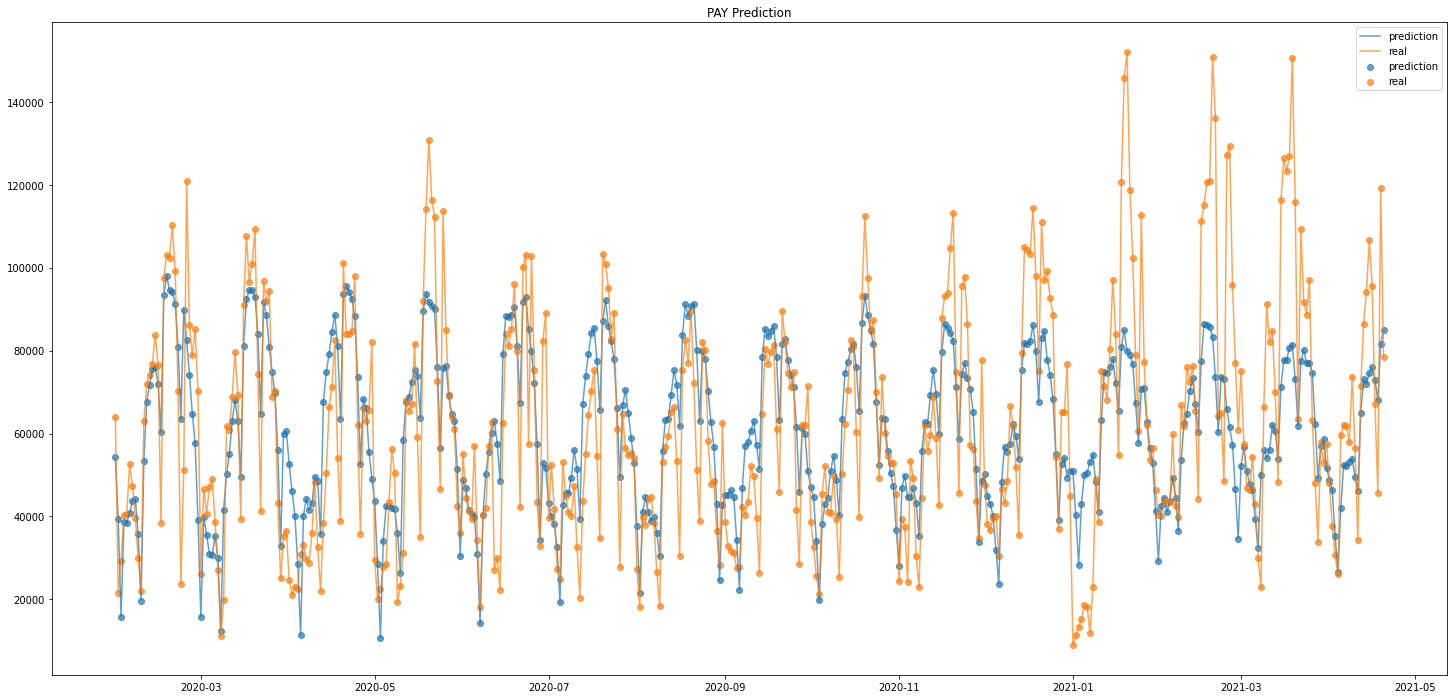

27.00091689673327

In [39]:
# Составим итоговое предсказание как сумму трех предсказаний
pred_full = arima_pred_trend + arima_pred_seasonal + arima_pred_residual
pred_full = pred_full.dropna()

plot_prediction(df, pred_full[pred_full.index>=START_DATE])

mape(df[(df.index>=START_DATE) & (df.index<=maxIndex)].PAY, 
     pred_full[(pred_full.index>=START_DATE) & (pred_full.index<=maxIndex)])

Раздельное предсказание каждой части и последующее суммирование показало себя лучше, чем предсказание неразделенного ряда.    
mape = 27.03

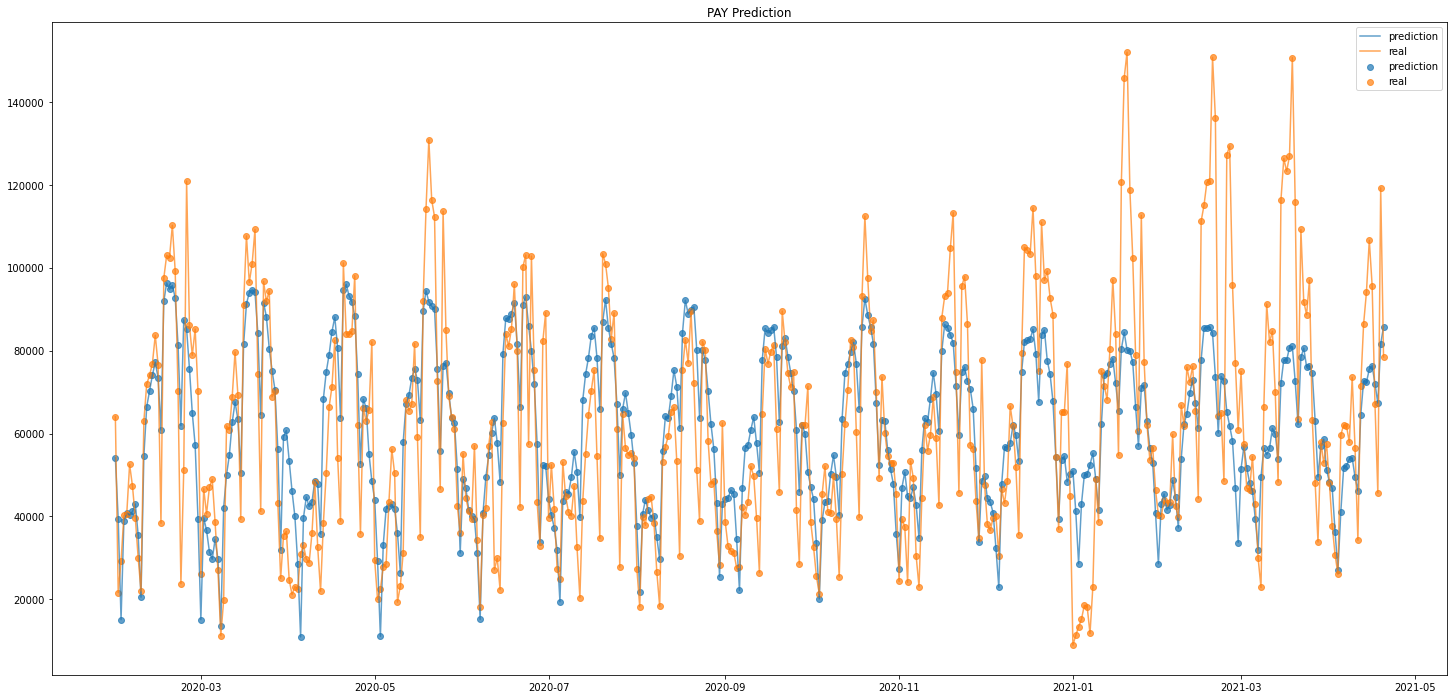

26.96585886628599

In [40]:
# Попробуем предсказать без учета шума
pred_full = arima_pred_trend + arima_pred_seasonal # + arima_pred_residual
pred_full = pred_full.dropna()

plot_prediction(df, pred_full[pred_full.index>=START_DATE])

mape(df[(df.index>=START_DATE) & (df.index<=maxIndex)].PAY, 
     pred_full[(pred_full.index>=START_DATE) & (pred_full.index<=maxIndex)])

Исключение шума из прогноза практически не изменило оценку предсказания.    
mape = 26.97

In [41]:
# Сохраним модели для итогового предсказания в ансамбле
# result_trend.save("result_trend.pickle")
# results_seasonal.save("results_seasonal.pickle")

# Предсказание с использованием DL

### Нормализация и разделение данных

Перед тем, как применять модели глубокого обучения, нормализуем данные, поскольку DL чувствительно к большим разбросам в значениях.

In [42]:
# Нормализуем
scaler = MinMaxScaler()
df_scal = scaler.fit_transform(df)
df_scal = pd.DataFrame(df_scal, columns=df.columns)

# Разделим на тренировочную и тестовую части
test = df_scal[df.index>=START_DATE]
train = df_scal[df.index<START_DATE]

Для построения нейронных сетей особым образом организуем данные. Каждому числу во временном ряду сопоставим набор признаков - предыдущие 30 дней. Будем считать, что именно за месяц происходят основные изменения в поведении данных. Для более глубокого обучения можно взять другой размер окна, например, = 365, то есть, год. Но это значительно увеличивает вычислительные ресурсы.

In [43]:
# Генерируем набор признаков из предыдущих значений для обучающей выборки
train_x = []
for i in range(INPUT_LEN, len(train)):
    train_x.append(train.iloc[i-INPUT_LEN:i])

train_y = train.iloc[INPUT_LEN:]

train_x = np.array(train_x)
train_y = np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))

In [44]:
# Генерируем набор признаков из предыдущих значений для тестовой выборки
test_x = []
for i in range(INPUT_LEN, len(test)):
    test_x.append(test.iloc[i-INPUT_LEN:i])

test_y = test.iloc[INPUT_LEN:]

test_x = np.array(test_x)
test_y = np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

In [45]:
# Проверим размеры выборок
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(4383, 30, 1) (4383, 1)
(416, 30, 1) (416, 1)


### CNN

Попробуем построить предсказание, используя свёрточные нейронные сети. В этих сетях предполагается, что все входы и выходы независимы. Однако в нашем случае входы - это скользящее окно, поэтому память о зависимостях между элементами ряда всё равно присутствует.

In [46]:
# Свёрточная сеть №1 
model_conv1 = Sequential()
model_conv1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(INPUT_LEN, 1)))
model_conv1.add(MaxPooling1D(pool_size=2))
model_conv1.add(Flatten())
model_conv1.add(Dense(128, activation='relu'))
model_conv1.add(Dense(64, activation='relu'))
model_conv1.add(Dense(1))
model_conv1.compile(optimizer='adam', loss='mape')

In [47]:
# Callback
checkpoint_conv1 = ModelCheckpoint('../working/conv1.hdf5' , monitor=['mape'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='mape', mode = "min", patience=10)
   
callbacks_list = [checkpoint_conv1, earlystop]

In [48]:
# Обучаем
model_conv1.fit(train_x, train_y, epochs=200, verbose=1, callbacks=callbacks_list)

Epoch 1/200
137/137 [==============================] - 1s 3ms/step - loss: 116.9917
Epoch 2/200
137/137 [==============================] - 0s 3ms/step - loss: 102.9685
Epoch 3/200
137/137 [==============================] - 0s 3ms/step - loss: 79.2110
Epoch 4/200
137/137 [==============================] - 0s 3ms/step - loss: 84.7251
Epoch 5/200
137/137 [==============================] - 0s 3ms/step - loss: 77.3318
Epoch 6/200
137/137 [==============================] - 0s 3ms/step - loss: 75.2941
Epoch 7/200
137/137 [==============================] - 0s 3ms/step - loss: 73.8632
Epoch 8/200
137/137 [==============================] - 0s 3ms/step - loss: 71.8391
Epoch 9/200
137/137 [==============================] - 0s 3ms/step - loss: 70.4523
Epoch 10/200
137/137 [==============================] - 0s 3ms/step - loss: 64.7114
Epoch 11/200
137/137 [==============================] - 0s 3ms/step - loss: 71.2585
Epoch 12/200
137/137 [==============================] - 0s 3ms/step - loss: 73.4962

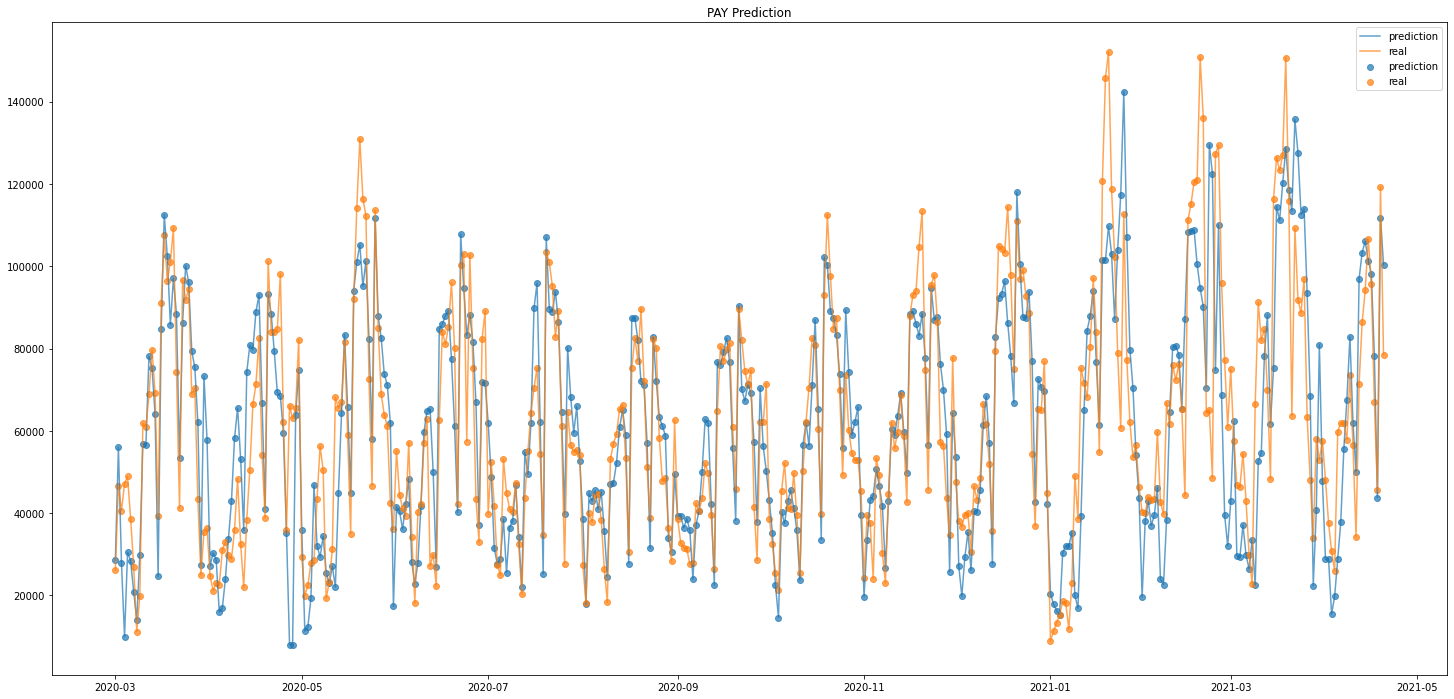

22.118349550015186

In [49]:
# Делаем предсказание и проверяем его
yhat = model_conv1.predict(test_x, verbose=0)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_conv1 = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_conv1.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_conv1.PAY)

mape лежит в пределах от 22.19 до 24.50

In [50]:
# Свёрточная сеть №2. Добавим еще больше свёрточных слоёв
model_conv2 = Sequential()
model_conv2.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(INPUT_LEN, 1)))
model_conv2.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_conv2.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_conv2.add(MaxPooling1D(pool_size=2))
model_conv2.add(Flatten())
model_conv2.add(Dense(100, activation='relu'))
model_conv2.add(Dense(1))
model_conv2.compile(optimizer='adam', loss='mape')

In [51]:
# Callback и обучение
checkpoint_conv2 = ModelCheckpoint('../working/conv2.hdf5' , monitor=['mape'], verbose=0  , mode='min')
callbacks_list = [checkpoint_conv2, earlystop]

# fit model
model_conv2.fit(train_x, train_y, epochs=200, verbose=1, callbacks=callbacks_list)

Epoch 1/200
137/137 [==============================] - 2s 8ms/step - loss: 99.4548
Epoch 2/200
137/137 [==============================] - 1s 8ms/step - loss: 84.2373
Epoch 3/200
137/137 [==============================] - 1s 8ms/step - loss: 86.0624
Epoch 4/200
137/137 [==============================] - 1s 8ms/step - loss: 84.7056
Epoch 5/200
137/137 [==============================] - 1s 8ms/step - loss: 74.2284
Epoch 6/200
137/137 [==============================] - 1s 8ms/step - loss: 73.4658
Epoch 7/200
137/137 [==============================] - 1s 8ms/step - loss: 71.6389
Epoch 8/200
137/137 [==============================] - 1s 8ms/step - loss: 73.7777
Epoch 9/200
137/137 [==============================] - 1s 8ms/step - loss: 75.5744
Epoch 10/200
137/137 [==============================] - 1s 8ms/step - loss: 73.6161
Epoch 11/200
137/137 [==============================] - 1s 8ms/step - loss: 73.7301
Epoch 12/200
137/137 [==============================] - 1s 8ms/step - loss: 69.6875
E

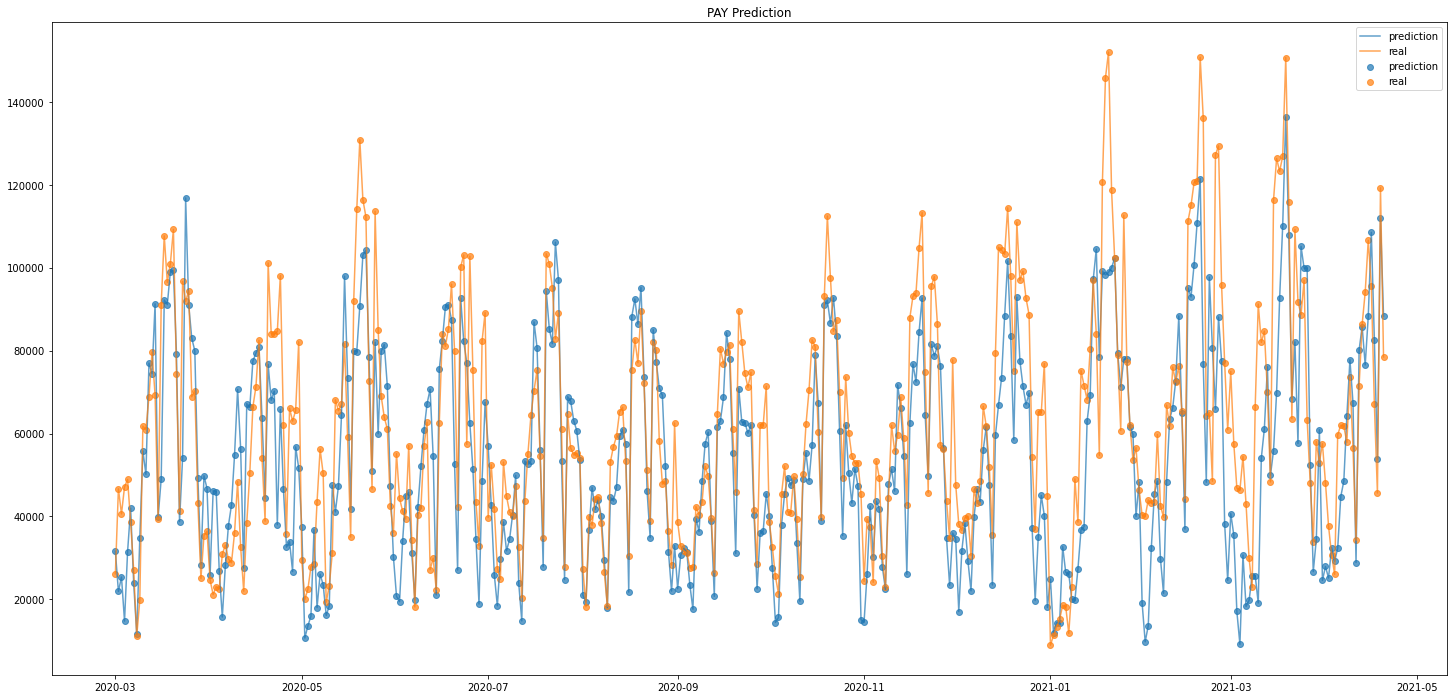

24.02765078431872

In [52]:
# Делаем предсказание и проверяем его
yhat = model_conv2.predict(test_x, verbose=0)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_conv2 = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_conv2.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_conv2.PAY)

Эта модель показывает примерно такой же результат: mape = от 22 до 24

### RNN

Рекуррентные сети оперируют последовательностями входов и эти последовательности обрабатываются целиком.     
Сначала построим простую рекуррентную сеть, а затем проверим, как предсказывает сеть с долговременной памятью LSTM.

In [53]:
# Простая рекуррентная сеть
model_rnn = Sequential()
model_rnn.add(SimpleRNN(48,activation="tanh",return_sequences=True, input_shape=(train_x.shape[1],1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(48,activation="tanh",return_sequences=True))
model_rnn.add(Dropout(0.02))
model_rnn.add(SimpleRNN(48,activation="tanh",return_sequences=False))
model_rnn.add(Dropout(0.02))
model_rnn.add(Dense(1))

optimizer = optimizers.RMSprop(lr=0.001, clipvalue=1.0)
model_rnn.compile(loss = "mse", optimizer = optimizer, metrics =['mae', 'mse', 'mape'])
# model_rnn.compile(optimizer="adam",loss="mape")

In [54]:
# Callback и обучение
checkpoint_rnn = ModelCheckpoint('../working/rnn.hdf5' , monitor=['mape'], verbose=0  , mode='min')
callbacks_list = [checkpoint_rnn, earlystop]

model_rnn.fit(train_x, train_y, epochs=20, batch_size=1, callbacks=callbacks_list)

Epoch 1/20
4383/4383 [==============================] - 48s 11ms/step - loss: 0.0763 - mae: 0.1979 - mse: 0.0763 - mape: 377.3738
Epoch 2/20
4383/4383 [==============================] - 47s 11ms/step - loss: 0.0099 - mae: 0.0735 - mse: 0.0099 - mape: 173.2721
Epoch 3/20
4383/4383 [==============================] - 46s 11ms/step - loss: 0.0080 - mae: 0.0648 - mse: 0.0080 - mape: 134.1562
Epoch 4/20
4383/4383 [==============================] - 45s 10ms/step - loss: 0.0061 - mae: 0.0562 - mse: 0.0061 - mape: 126.3310
Epoch 5/20
4383/4383 [==============================] - 45s 10ms/step - loss: 0.0059 - mae: 0.0541 - mse: 0.0059 - mape: 121.2867
Epoch 6/20
4383/4383 [==============================] - 44s 10ms/step - loss: 0.0060 - mae: 0.0559 - mse: 0.0060 - mape: 140.5347
Epoch 7/20
4383/4383 [==============================] - 44s 10ms/step - loss: 0.0056 - mae: 0.0531 - mse: 0.0056 - mape: 129.5137
Epoch 8/20
4383/4383 [==============================] - 44s 10ms/step - loss: 0.0059 - mae

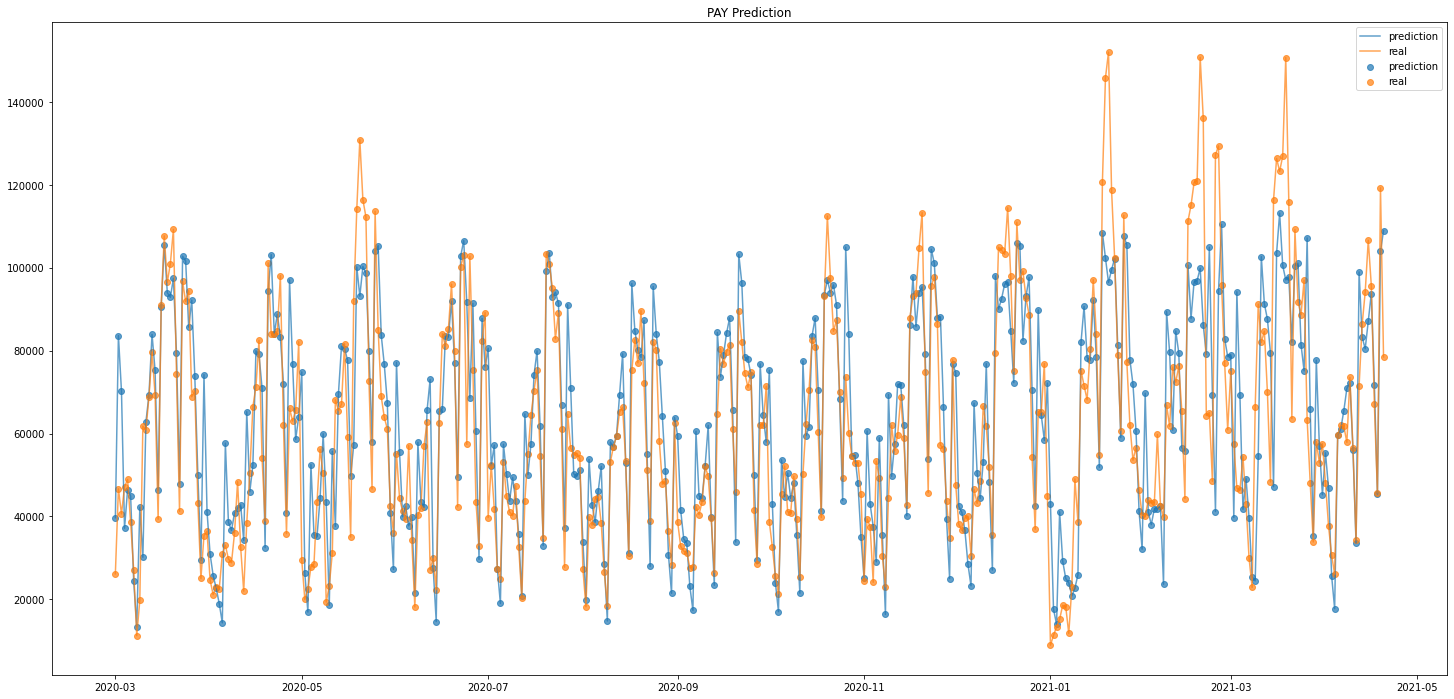

22.264391842498835

In [55]:
# Предсказываем и проверяем
yhat = model_rnn.predict(test_x, batch_size=1)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_rnn = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_rnn.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_rnn.PAY)

Метрика mape примерно такая же, как у свёрточных сетей.

Построим простую сеть LSTM.

In [56]:
# LSTM-модель №1
model_lstm = Sequential()
model_lstm.add(LSTM(units=10, stateful=True, return_sequences=True, batch_input_shape=(1, train_x.shape[1], 1)))
model_lstm.add(LSTM(units=10, stateful=True, return_sequences=True))
model_lstm.add(LSTM(units=10, stateful=True, return_sequences=True))
model_lstm.add(LSTM(units=10))
model_lstm.add(Dense(units=1))

# model_lstm.compile(optimizer="adam", loss="mape") # RMSprop
optimizer = optimizers.RMSprop(lr=0.001, clipvalue=1.0)
model_lstm.compile(loss = "mse", optimizer = optimizer, metrics =['mape'])

In [59]:
# Callback и обучение
checkpoint_lstm = ModelCheckpoint('../working/lstm.hdf5' , monitor=['mape'], verbose=0  , mode='min')
callbacks_list = [checkpoint_lstm, earlystop]

model_lstm.fit(train_x, train_y, epochs=5, batch_size=1, callbacks=callbacks_list)

Epoch 1/5
4383/4383 [==============================] - 94s 21ms/step - loss: 0.0125 - mape: 269.8761
Epoch 2/5
4383/4383 [==============================] - 94s 21ms/step - loss: 0.0124 - mape: 269.7176
Epoch 3/5
4383/4383 [==============================] - 93s 21ms/step - loss: 0.0125 - mape: 270.6966
Epoch 4/5
4383/4383 [==============================] - 93s 21ms/step - loss: 0.0125 - mape: 271.9673
Epoch 5/5
4383/4383 [==============================] - 93s 21ms/step - loss: 0.0125 - mape: 273.8737


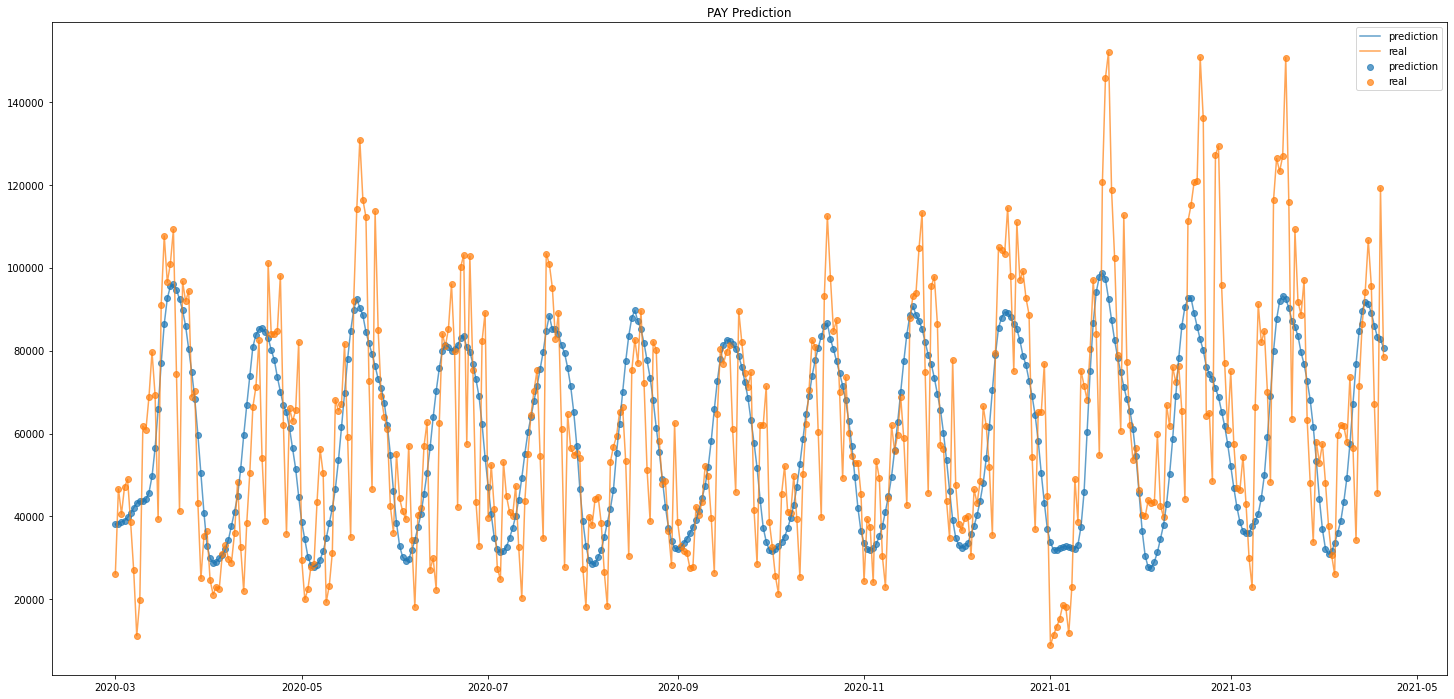

31.486227716777464

In [60]:
# Предсказываем и проверяем
yhat = model_lstm.predict(test_x, batch_size=1)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_lstm = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_lstm.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_lstm.PAY)

По монитору обучения,а также по графику видно, что сеть не очень успешно обучается, и метрика на выходе невелика.         
       
Попробуем применить двунаправленную сеть LSTM.

In [61]:
# LSTM-модель №2
model_bi_lstm = Sequential()
model_bi_lstm.add(Bidirectional(LSTM(units=48, stateful=True, return_sequences=True, 
                          input_shape=(train_x.shape[1],1))))
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(units=48, stateful=True, return_sequences=True)))
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(units=48, stateful=True, return_sequences=True)))
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(units=48)))
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(units=1))

# 10 = 38, 32 = 32 # 32 = 27.31146940644043, 48 = 26.569509165594816
optimizer = optimizers.RMSprop(lr=0.001, clipvalue=1.0)
# model_bi_lstm.compile(optimizer="adam", loss="mape") # RMSprop
model_bi_lstm.compile(loss = "mse", optimizer = optimizer, metrics =['mae', 'mse', 'mape'])

In [62]:
# Callback и обучение
checkpoint_bi_lstm = ModelCheckpoint('../working/bi_lstm.hdf5' , monitor=['mape'], verbose=0  , mode='min')
callbacks_list = [checkpoint_bi_lstm, earlystop]

model_bi_lstm.fit(train_x, train_y, epochs=5, batch_size=1, callbacks=callbacks_list)

Epoch 1/5
4383/4383 [==============================] - 150s 32ms/step - loss: 0.0192 - mae: 0.1042 - mse: 0.0192 - mape: 332.6641
Epoch 2/5
4383/4383 [==============================] - 136s 31ms/step - loss: 0.0104 - mae: 0.0758 - mse: 0.0104 - mape: 227.0855
Epoch 3/5
4383/4383 [==============================] - 135s 31ms/step - loss: 0.0078 - mae: 0.0636 - mse: 0.0078 - mape: 187.7696
Epoch 4/5
4383/4383 [==============================] - 135s 31ms/step - loss: 0.0061 - mae: 0.0551 - mse: 0.0061 - mape: 139.1501
Epoch 5/5
4383/4383 [==============================] - 135s 31ms/step - loss: 0.0053 - mae: 0.0502 - mse: 0.0053 - mape: 166.4296


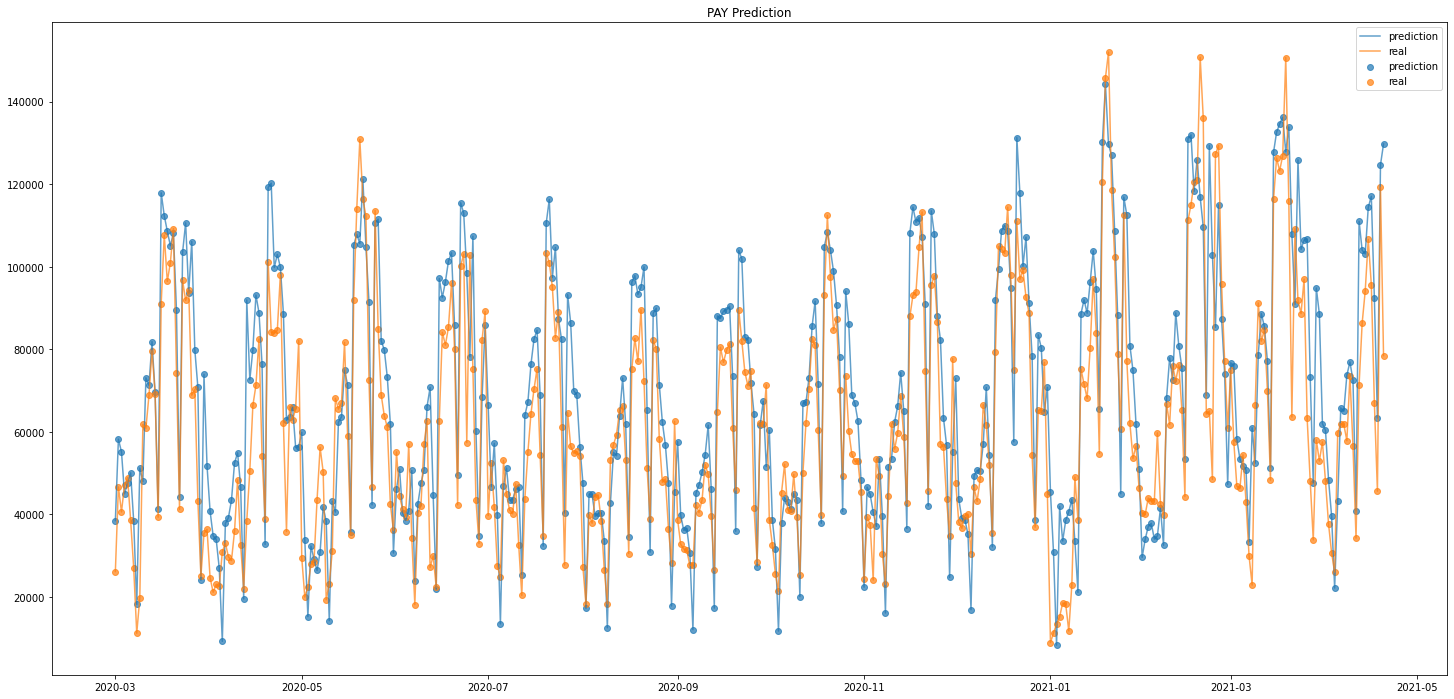

25.832503008425917

In [63]:
# Предсказываем и проверяем
yhat = model_bi_lstm.predict(test_x, batch_size=1)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_bi_lstm = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_bi_lstm.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_bi_lstm.PAY)

Данная модель работает нестабильно. Иногда метрика предсказания получается неплохая - около 20%, но иногда она выходит почти 100%.

### CNN + RNN

Идея одновременного применения свёртки и рекурретности заключается в том, чтобы понизить размерность, выделив главные связи между входами, а затем уже применять рекурретное обучение.

In [64]:
# Модель CNN+RNN №1
model_sr1 = Sequential()
model_sr1.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model_sr1.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_sr1.add(MaxPooling1D(pool_size=2))
model_sr1.add(Flatten())
model_sr1.add(RepeatVector(30))
model_sr1.add(LSTM(128, activation='relu'))
model_sr1.add(Dense(100, activation='relu'))
model_sr1.add(Dense(1))
# model_sr1.compile(loss='mape', optimizer='adam')

model_sr1.compile(loss = "mse", optimizer = optimizer, metrics =['mae', 'mse', 'mape'])

In [65]:
# Callback и обучение
checkpoint_sr1 = ModelCheckpoint('../working/sr1.hdf5' , monitor=['mape'], verbose=0  , mode='min')
callbacks_list = [checkpoint_sr1, earlystop]

model_sr1.fit(train_x, train_y, epochs=10, callbacks=callbacks_list)

Epoch 1/10
137/137 [==============================] - 18s 117ms/step - loss: 0.0207 - mae: 0.0993 - mse: 0.0207 - mape: 243.4737
Epoch 2/10
137/137 [==============================] - 16s 115ms/step - loss: 0.0053 - mae: 0.0503 - mse: 0.0053 - mape: 136.1044
Epoch 3/10
137/137 [==============================] - 16s 116ms/step - loss: 0.0047 - mae: 0.0475 - mse: 0.0047 - mape: 157.7939
Epoch 4/10
137/137 [==============================] - 16s 115ms/step - loss: 0.0039 - mae: 0.0423 - mse: 0.0039 - mape: 106.2612
Epoch 5/10
137/137 [==============================] - 16s 117ms/step - loss: 0.0037 - mae: 0.0403 - mse: 0.0037 - mape: 125.9097
Epoch 6/10
137/137 [==============================] - 16s 115ms/step - loss: 0.0037 - mae: 0.0392 - mse: 0.0037 - mape: 110.6662
Epoch 7/10
137/137 [==============================] - 16s 117ms/step - loss: 0.0031 - mae: 0.0375 - mse: 0.0031 - mape: 115.5625
Epoch 8/10
137/137 [==============================] - 16s 114ms/step - loss: 0.0032 - mae: 0.0360

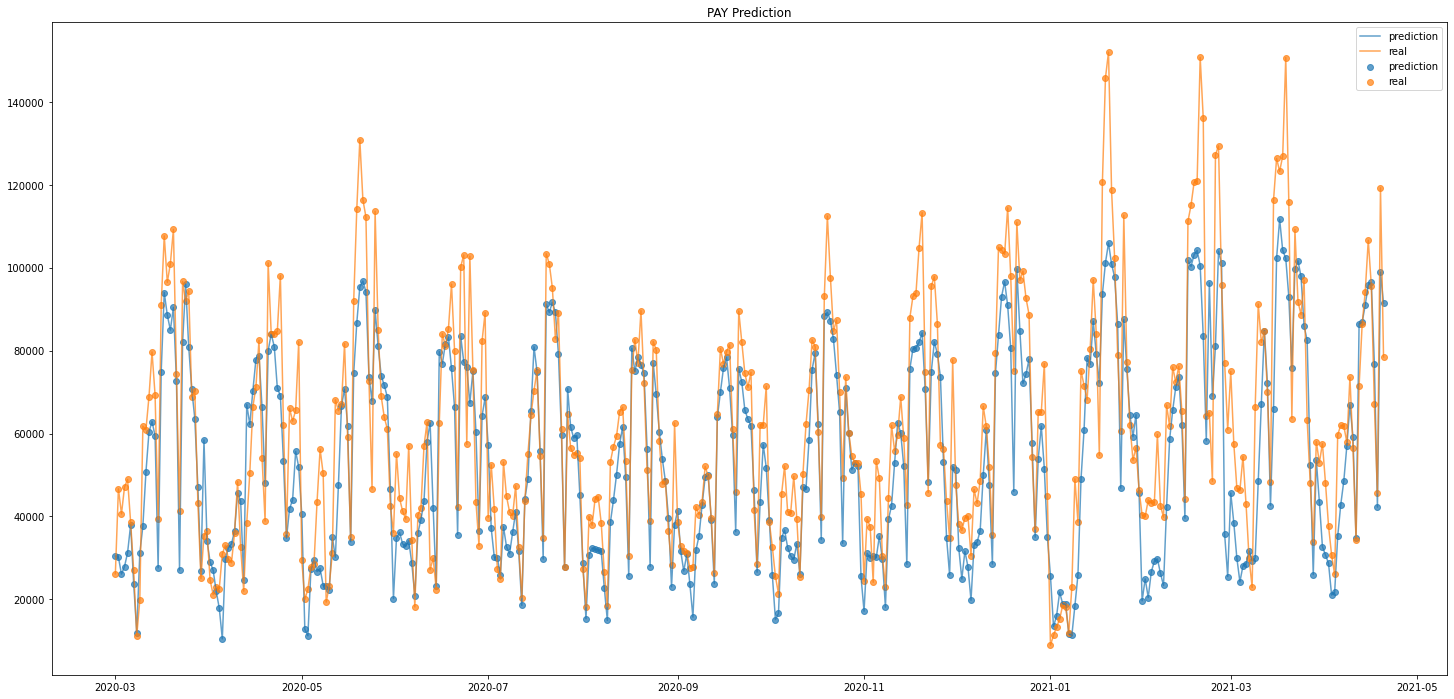

19.050722308821715

In [66]:
# Предсказываем и проверяем
yhat = model_sr1.predict(test_x, batch_size=1)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_sr1 = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_sr1.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_sr1.PAY)

mape = 19.86

In [67]:
# Модель CNN+RNN №2
model_sr2 = Sequential()
model_sr2.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model_sr2.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model_sr2.add(MaxPooling1D(pool_size=2))
model_sr2.add(Flatten())
model_sr2.add(RepeatVector(30))
model_sr2.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_sr2.add(Dropout(0.2))
model_sr2.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_sr2.add(Dropout(0.2))
model_sr2.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_sr2.add(LSTM(units=100, return_sequences=True, activation='relu'))
model_sr2.add(Bidirectional(LSTM(128, activation='relu')))
model_sr2.add(Dense(100, activation='relu'))
model_sr2.add(Dense(1))
model_sr2.compile(loss = "mse", optimizer = optimizer, metrics =['mae', 'mse', 'mape'])

In [68]:
# Callback и обучение
checkpoint_sr2 = ModelCheckpoint('../working/sr2.hdf5' , monitor=['mape'], verbose=0  , mode='min')
callbacks_list = [checkpoint_sr2, earlystop]

model_sr2.fit(train_x, train_y, epochs=15, callbacks=callbacks_list)

Epoch 1/15
137/137 [==============================] - 35s 203ms/step - loss: 0.1657 - mae: 0.1367 - mse: 0.1657 - mape: 266.3289
Epoch 2/15
137/137 [==============================] - 27s 200ms/step - loss: 0.0090 - mae: 0.0707 - mse: 0.0090 - mape: 183.5715
Epoch 3/15
137/137 [==============================] - 28s 204ms/step - loss: 0.0109 - mae: 0.0618 - mse: 0.0109 - mape: 190.7206
Epoch 4/15
137/137 [==============================] - 28s 201ms/step - loss: 0.0065 - mae: 0.0563 - mse: 0.0065 - mape: 171.9935
Epoch 5/15
137/137 [==============================] - 28s 201ms/step - loss: 0.0050 - mae: 0.0505 - mse: 0.0050 - mape: 132.6877
Epoch 6/15
137/137 [==============================] - 28s 203ms/step - loss: 0.0042 - mae: 0.0455 - mse: 0.0042 - mape: 135.8183
Epoch 7/15
137/137 [==============================] - 28s 202ms/step - loss: 0.0041 - mae: 0.0450 - mse: 0.0041 - mape: 110.7670
Epoch 8/15
137/137 [==============================] - 28s 202ms/step - loss: 0.0042 - mae: 0.0439

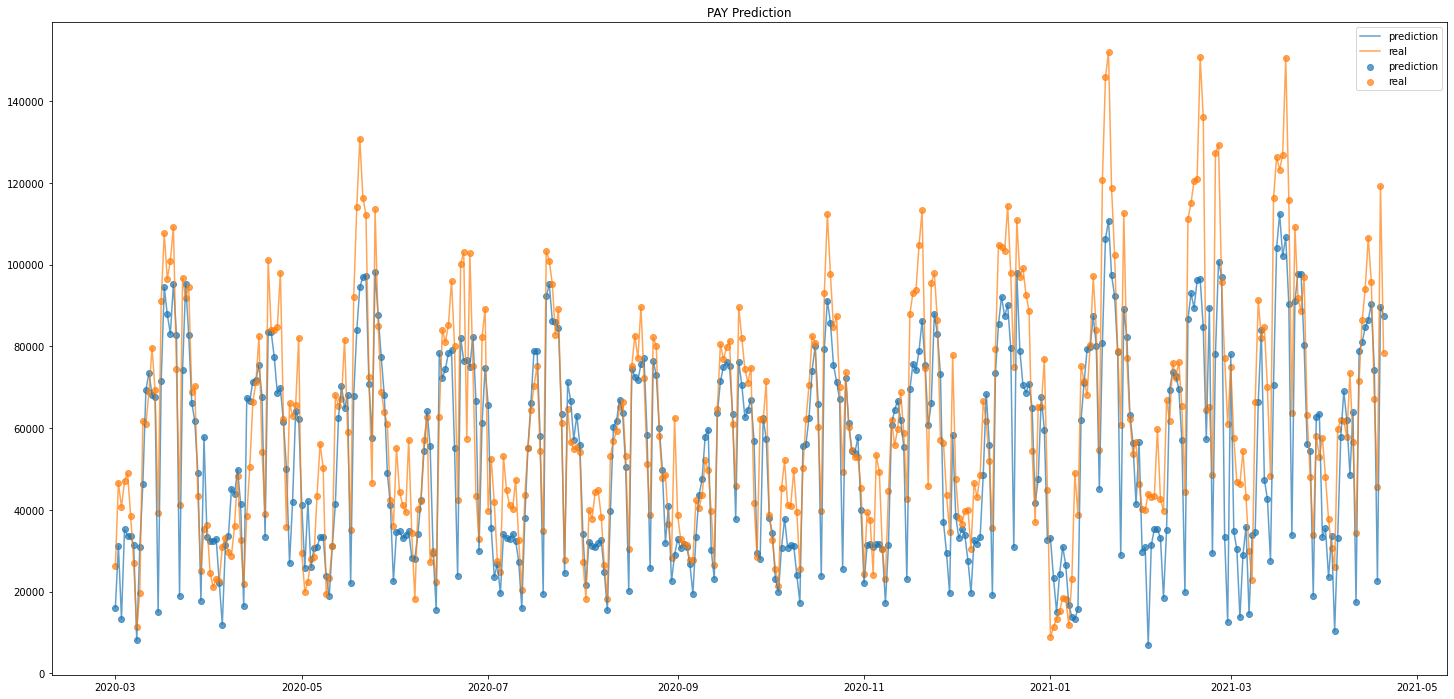

22.59105196083081

In [69]:
# Предсказываем и проверяем
yhat = model_sr2.predict(test_x, batch_size=1)

temp = df_scal[-PRED_LEN+INPUT_LEN:]
temp.PAY = yhat
prediction_sr2 = pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction_sr2.PAY)
mape(df.PAY[-PRED_LEN+INPUT_LEN:],prediction_sr2.PAY)

mape = 22.64

**Выводы по использованию моделей ML и DL:**     
1. Чистая модель SARIMAX предсказывает не очень хорошо. Её оценка mape = 40-50%. Но декомпозиция ряда и прогнозирование отдельных составляющих с последующим сложением уменьшает оценку до 27%.     
2. Модели DL существенно лучше дают прогноз, нежели ML-модель SARIMAX. Оценка Возможно, и SARIMAX даст неплохие предсказания, если увеличить параметр p. При его увеличении SARIMAX соответственно улучшает и оценку. Однако при p=10 вычисление затягивается почти на час (на платформе Kaggle), а при p=12 возникает ошибка переполнения памяти.     
3. Чистая модель RNN и однонаправленная модель LSTM с предсказанием справляются плохо. Чистые свёрточные модели предсказывают стабильно на уровне 23-26%.     
4. Сети с архитектурой CNN+RNN дают наилучший прогноз. Их оценка 19-20%.

# Предсказание с использованием специальной модели Prophet

Модель Prophet разработана командой Facebook специально для обработки временных рядов. Она построена не на нейронных сетях, а на ML-подходах. Главная особенность Prophet - это умение моделью раскладывать временной ряд на сумму рядов: тренд, сезонность, аномальные дни и остаток. Известно, что годовая сезонность моделируется в Prophet рядами Фурье, а сезонность - кусочно-линейными функциями.     
     
Prophet позволяет учитывать выходные, праздники и дни, когда в ряду показатели либо экстремально падают, либо вырастают. Кроме того, Prophet умеет обрабатывать дополнительные регрессоры, то есть признаки, которые сопутствуют главному показателю (в нашем случае это оплаты) и влияют на его поведение.     
     
Данные для Prophet можно не нормализовать, так как это делает сама модель. Это было проверено опытным путём. Результаты на исходных данных и нормализованных полностью совпадали.

Для работы с Prophet временной ряд должен иметь стандартные названия для двух признаков: **ds** - для даты и **y** - для прогнозируемого признака.

In [70]:
# Готовим данные для Prophet - переименовываем признаки
df_pr = df.copy()
df_pr = df_pr.reset_index()
df_pr.columns = ['ds','y'] 

# Разбиваем на тренировочные и тестовые
train_data_pr = df_pr.iloc[:len(df)-PRED_LEN]
test_data_pr = df_pr.iloc[len(df)-PRED_LEN:]

Для учёта нерабочих дней загрузим из библиотеки holidays данные о праздничных днях в России. Эта библиотека не учитывает переносы выходных на другие дни, принятые у нас в стране, но лучше иметь неполную информацию, чем не иметь её вовсе.    
Для применения списка выходных дней в модели, их тоже необходимо назвать специальным образом.

In [71]:
# Датасет для передачи параметром в модель
holiday = pd.DataFrame()

# Получаем данные о выходных днях и готовим для модели
for date, name in sorted(holidays.Russia(years=list(range(2008,2022))).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "Ru-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday

ds      holiday
0   2008-01-01  Ru-Holidays
1   2008-01-02  Ru-Holidays
2   2008-01-03  Ru-Holidays
3   2008-01-04  Ru-Holidays
4   2008-01-05  Ru-Holidays
..         ...          ...
191 2021-03-08  Ru-Holidays
192 2021-05-01  Ru-Holidays
193 2021-05-09  Ru-Holidays
194 2021-06-12  Ru-Holidays
195 2021-11-04  Ru-Holidays

[196 rows x 2 columns]

Для учета аномальных дней можно построить дополнительные признаки и указать модели, что их надо учитывать при прогнозировании.     
      
Аномальными будем считать воскресенья, когда кассы ЭСК закрыты и оплата поступает только через онлайн-сервисы. Также укажем, что до 12-го числа оплат очень мало (это связано с тем, что счета выставляют в начале месяца и их не спешат сразу оплачивать, ожидая зарплаты). Дополнительно укажем, что в промежутке между 17 и 25 числом оплат, напротив, очень много.   
    
Кроме того, укажем модели, что надо при прогнозировании учитывать день недели и день в году. То, что эти признаки важны, получено опытным путём. Ниже на графиках показаны сезонные колебания прогнозируемого признака, на основании которых строились дополнительные регрессоры.

In [72]:
# Временный набор данных для исследования сезонности
dft = df.copy().reset_index()
dft['year'] = dft['Date'].dt.year
dft['month'] = dft['Date'].dt.month
dft['day'] = dft['Date'].dt.day
dft['day_of_year'] = dft['Date'].dt.dayofyear
dft['week_of_year'] = dft['Date'].dt.weekofyear
dft['quarter'] = dft['Date'].dt.quarter
dft['season'] = dft.month%12 // 3 + 1
dft['day_of_week'] = dft['Date'].dt.dayofweek

dft[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season', 'day_of_week']].head()

Date  year  month  day  day_of_year  week_of_year  quarter  season  \
0 2008-01-01  2008      1    1            1             1        1       1   
1 2008-01-02  2008      1    2            2             1        1       1   
2 2008-01-03  2008      1    3            3             1        1       1   
3 2008-01-04  2008      1    4            4             1        1       1   
4 2008-01-05  2008      1    5            5             1        1       1   

   day_of_week  
0            1  
1            2  
2            3  
3            4  
4            5

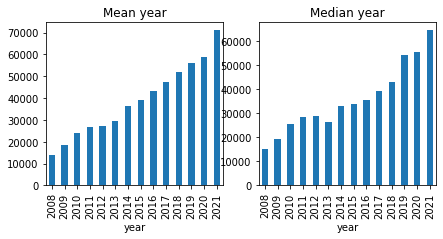

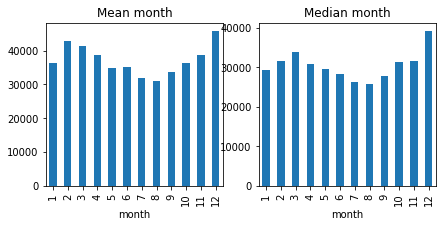

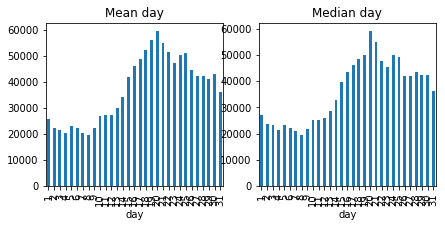

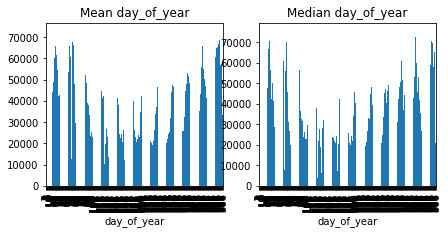

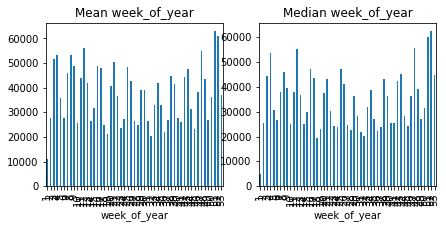

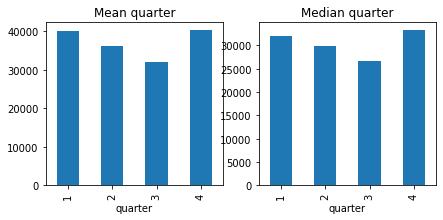

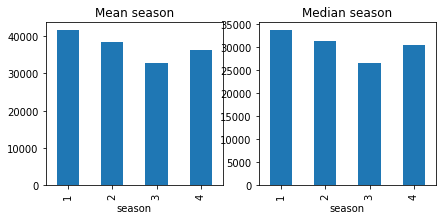

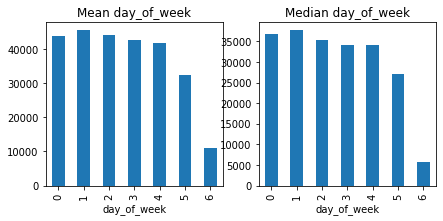

In [73]:
# Графики для проверки сезонности по новым признакам
for col in ['year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season', 'day_of_week']:
    fig, ax = plt.subplots(1, 2, figsize=(7,3))
    ax[0].set_title('Mean ' + col)
    dft.groupby(by = col).mean()['PAY'].plot(ax=ax[0], kind='bar')
    ax[1].set_title('Median ' + col)
    dft.groupby(by = col).median()['PAY'].plot(ax=ax[1], kind='bar')

Тренд по годам - почти линейный. Причина - инфляция и рост тарифов.     
По месяцам - оплаты падают летом и резко возрастают в декабре перед окончанием года и в феврале, когда приходят первые деньги после новогодних каникул.     
Графики по дням в году, по неделям в году, по сезонам и по кварталам практически совпадают с графиком месяцев в году. Поэтому все эти графики избыточны.   
На графики распределения величины по дням месяца и дням недели посмотрим подробнее, построив их в другом масштабе.

<AxesSubplot:title={'center':'Mean day of week'}, xlabel='day_of_week'>

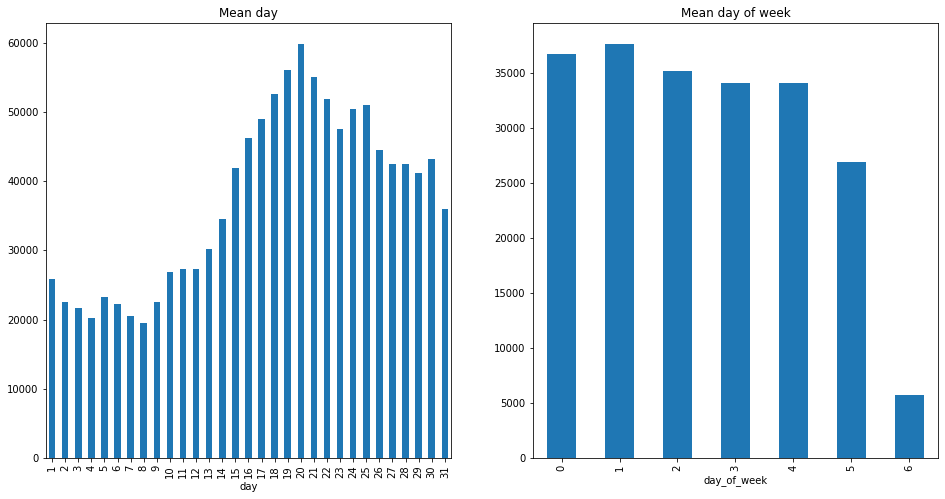

In [74]:
# Графики более подробного рассмотрения сезонности по дням месяца и дням недели
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].set_title('Mean day' )
dft.groupby(by = 'day').mean()['PAY'].plot(ax=ax[0], kind='bar')
ax[1].set_title('Mean day of week' )
dft.groupby(by = 'day_of_week').median()['PAY'].plot(ax=ax[1], kind='bar')

График оплат по дням месяца показывает, что оплат значительно меньше до 12-го числа включительно и существенно больше в интервале с 17 по 25 число.    
График оплаты по дням недели резко выделяет только один день - воскресенье.     
     
Учтём все эти наблюдения при построении регрессоров для Prophet.

In [75]:
# Функция для построения признака воскресенья
def sunday_date(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6:
        return 1
    else:
        return 0

# Функция для построения признака дней, когда поступления оплат резко падают
def bad_date(ds):
    date = pd.to_datetime(ds)
    if date.day < 12:
        return 1
    else:
        return 0

# Функция для построения признака дней, когда поступления оплат резко возрастают
def good_date(ds):
    date = pd.to_datetime(ds)
    if date.day <= 25 and date.day >=17:
        return 1
    else:
        return 0

In [76]:
# Добавляем дополнительные признаки, влияющие на прогноз
train_data_pr['day_of_year'] = train_data_pr['ds'].dt.dayofyear
train_data_pr['day_of_week'] = train_data_pr['ds'].dt.day_of_week
train_data_pr['sunday_date'] = train_data_pr['ds'].apply(sunday_date)
train_data_pr['bad_date'] = train_data_pr['ds'].apply(bad_date)
train_data_pr['good_date'] = train_data_pr['ds'].apply(good_date)

Оптимальные параметры для Prophet были получены при помощи самодельного GridSearch. Код поиска параметров приводится ниже в виде закомментаренных ячеек.

In [77]:
# Модель Prophet
model_prop = Prophet(holidays=holiday,        # учёт праздников 
             changepoint_prior_scale = 0.001, # шаг сетки для поисков локальных экстремумов
             weekly_seasonality = True,       # учёт недельной сезонности
             yearly_seasonality = True,       # учет годовой сезонности
             n_changepoints = 100             # количество экстремумов (не очень ясный параметр)
            )

# Добавляем регрессоры, то есть указываем, какие дополнительные признаки влияют на прогноз
model_prop.add_regressor('sunday_date')
model_prop.add_regressor('bad_date')
model_prop.add_regressor('good_date')
model_prop.add_regressor('day_of_year')
model_prop.add_regressor('day_of_week')

In [78]:
# Обучаем модель
model_prop.fit(train_data_pr)

# Строим временной ряд, который содержит тренировочные даты + предсказываемые даты
future = model_prop.make_future_dataframe(periods=PRED_LEN)
future

ds
0    2008-01-01
1    2008-01-02
2    2008-01-03
3    2008-01-04
4    2008-01-05
...         ...
4854 2021-04-16
4855 2021-04-17
4856 2021-04-18
4857 2021-04-19
4858 2021-04-20

[4859 rows x 1 columns]

In [79]:
# К ряду также добавляем дополнительные признаки
future['sunday_date'] = future['ds'].apply(sunday_date)
future['bad_date'] = future['ds'].apply(bad_date)
future['good_date'] = future['ds'].apply(good_date)
future['day_of_year'] = future['ds'].dt.dayofyear
future['day_of_week'] = future['ds'].dt.day_of_week

In [81]:
# Предсказываем и проверяем результат
forecast = model_prop.predict(future) 
forecast

ds         trend    yhat_lower     yhat_upper   trend_lower  \
0    2008-01-01  14616.618422 -25763.924406    3282.372749  14616.618422   
1    2008-01-02  14626.589467 -27358.853145    3708.337773  14626.589467   
2    2008-01-03  14636.560513 -28450.813350     921.972172  14636.560513   
3    2008-01-04  14646.531558 -29192.835545    1412.251698  14646.531558   
4    2008-01-05  14656.502604 -39121.756716   -6888.336313  14656.502604   
...         ...           ...           ...            ...           ...   
4854 2021-04-16  63017.091605  54026.598219   84090.484278  63017.085901   
4855 2021-04-17  63027.063005  57734.474372   88948.737289  63027.057279   
4856 2021-04-18  63037.034404  35658.479743   66436.677027  63037.028657   
4857 2021-04-19  63047.005803  68491.473220   99386.885882  63047.000036   
4858 2021-04-20  63056.977203  70217.973815  101256.245095  63056.971416   

       trend_upper   Ru-Holidays  Ru-Holidays_lower  Ru-Holidays_upper  \
0     14616.618422 -23172.950465      -23172.950465      -23172.950465   
1     14626.589467 -23172.950465      -23172.950465      -23172.950465   
2     14636.560513 -23172.950465      -23172.950465      -23172.950465   
3     14646.531558 -23172.950465      -23172.950465      -23172.950465   
4     14656.502604 -23172.950465      -23172.950465      -23172.950465   
...            ...           ...                ...                ...   
4854  63017.097013      0.000000           0.000000           0.000000   
4855  63027.068419      0.000000           0.000000           0.000000   
4856  63037.039839      0.000000           0.000000           0.000000   
4857  63047.011259      0.000000           0.000000           0.000000   
4858  63056.982679      0.000000           0.000000           0.000000   

      additive_terms  ...        weekly  weekly_lower  weekly_upper  \
0      -26353.703772  ...   2272.206343   2272.206343   2272.206343   
1      -27530.407358  ...   3394.758648   3394.758648   3394.758648   
2      -28602.120119  ...   4672.238221   4672.238221   4672.238221   
3      -29064.487340  ...   6610.147286   6610.147286   6610.147286   
4      -37374.551150  ...    751.871323    751.871323    751.871323   
...              ...  ...           ...           ...           ...   
4854     5749.622141  ...   6610.147286   6610.147286   6610.147286   
4855     9783.570098  ...    751.871323    751.871323    751.871323   
4856   -11865.716961  ... -15561.779470 -15561.779470 -15561.779470   
4857    20949.888720  ...  -2139.442352  -2139.442352  -2139.442352   
4858    22336.214315  ...   2272.206343   2272.206343   2272.206343   

            yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0      9529.159768   9529.159768   9529.159768                   0.0   
1     10045.892623  10045.892623  10045.892623                   0.0   
2     10512.689034  10512.689034  10512.689034                   0.0   
3     10928.401493  10928.401493  10928.401493                   0.0   
4     11292.602391  11292.602391  11292.602391                   0.0   
...            ...           ...           ...                   ...   
4854   5479.796361   5479.796361   5479.796361                   0.0   
4855   5351.850717   5351.850717   5351.850717                   0.0   
4856   5194.246001   5194.246001   5194.246001                   0.0   
4857   5009.262880   5009.262880   5009.262880                   0.0   
4858   4799.928525   4799.928525   4799.928525                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0 -11737.085351  
1                            0.0                         0.0 -12903.817891  
2                            0.0                         0.0 -13965.559606  
3                            0.0                         0.0 -14417.955781  
4                            0.0                         0.0 -22718.048546  
...                          ..

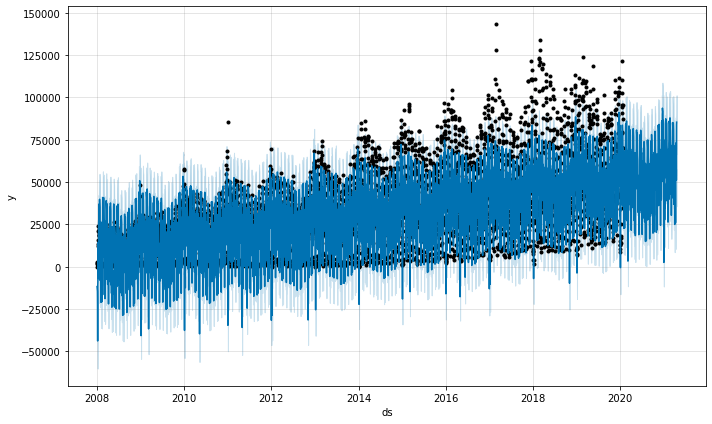

In [82]:
# Визуализируем прогноз. Синим показано предсказание, чёрным - исходные данные
fig1 = model_prop.plot(forecast)

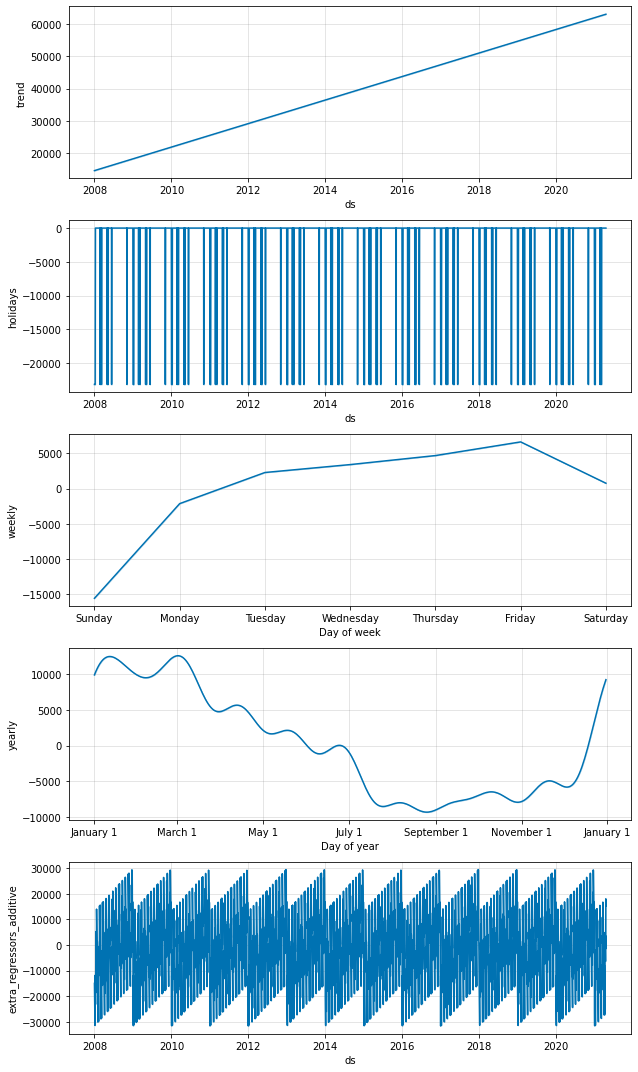

In [83]:
# Визуализируем составлющие ряда, выделенные моделью 
fig2 = model_prop.plot_components(forecast)

Выданный прогноз содержит множество информации. Нас интересует столбец yhat, так как в нем находится прогноз для текущей даты.

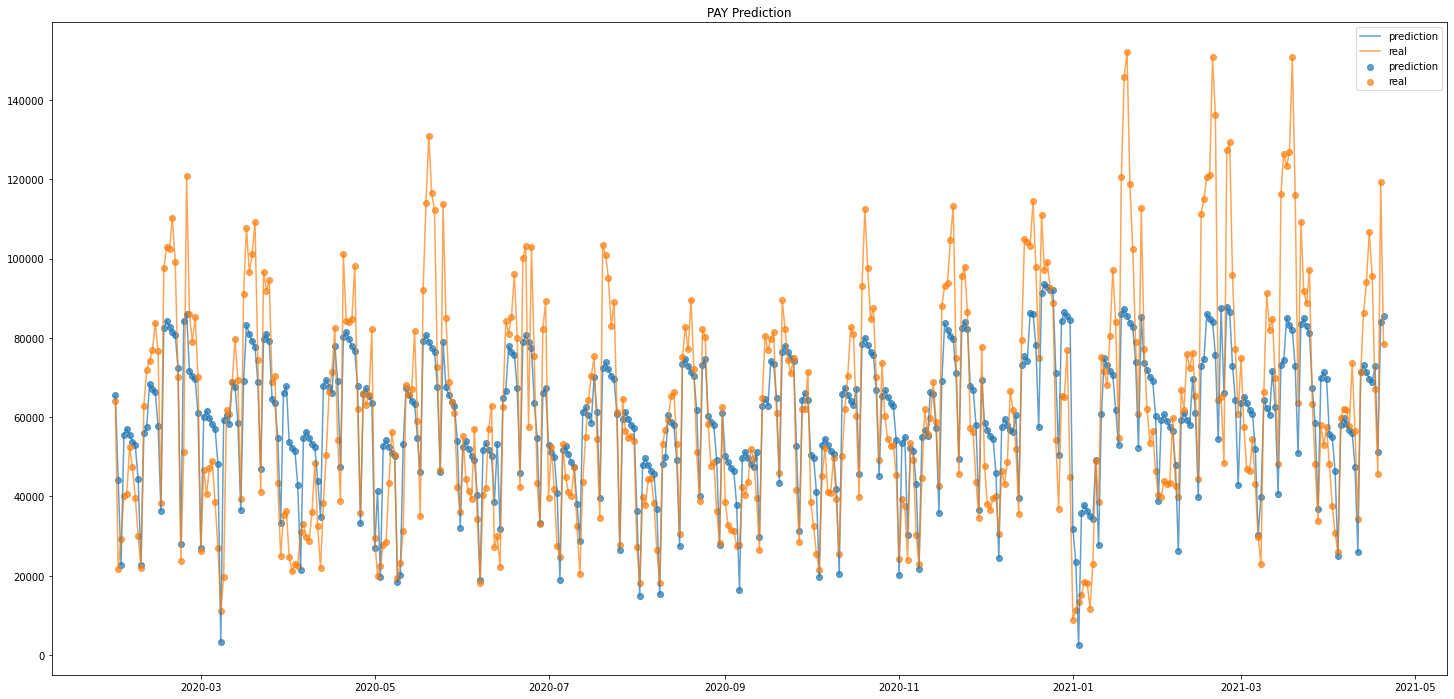

24.16467986514035

In [84]:
# Выделяем из полного прогноза ряд предсказания
prediction_prop = forecast[forecast.ds>=START_DATE][['ds','yhat']]
prediction_prop = prediction_prop.rename(columns = {'ds': 'Date', 'yhat': 'PAY'})
prediction_prop = prediction_prop.set_index('Date')

# График и оценка
plot_prediction(df, prediction_prop.PAY)
mape(df[df.index>=START_DATE].PAY, prediction_prop.PAY) 

По графику видно, что Prophet не справляется с пиковыми значениями величины. Это известная проблема - Prophet считает эти значения выбросами и игнорирует их. Решение проблемы пока не найдено. Возможно, надо более тщательно подобрать параметры.

In [85]:
# Сохраним модель
# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  

# К сожалению, при сохранении происходит ошибка, которую непонятно как исправлять

# Воспользуемся простым pickle
# with open('prophet.pickle', 'wb') as f:
#     pickle.dump(model_prop, f)

Для уменьшения значений в пиковых точках попробуем прологарифмировать наш ряд.

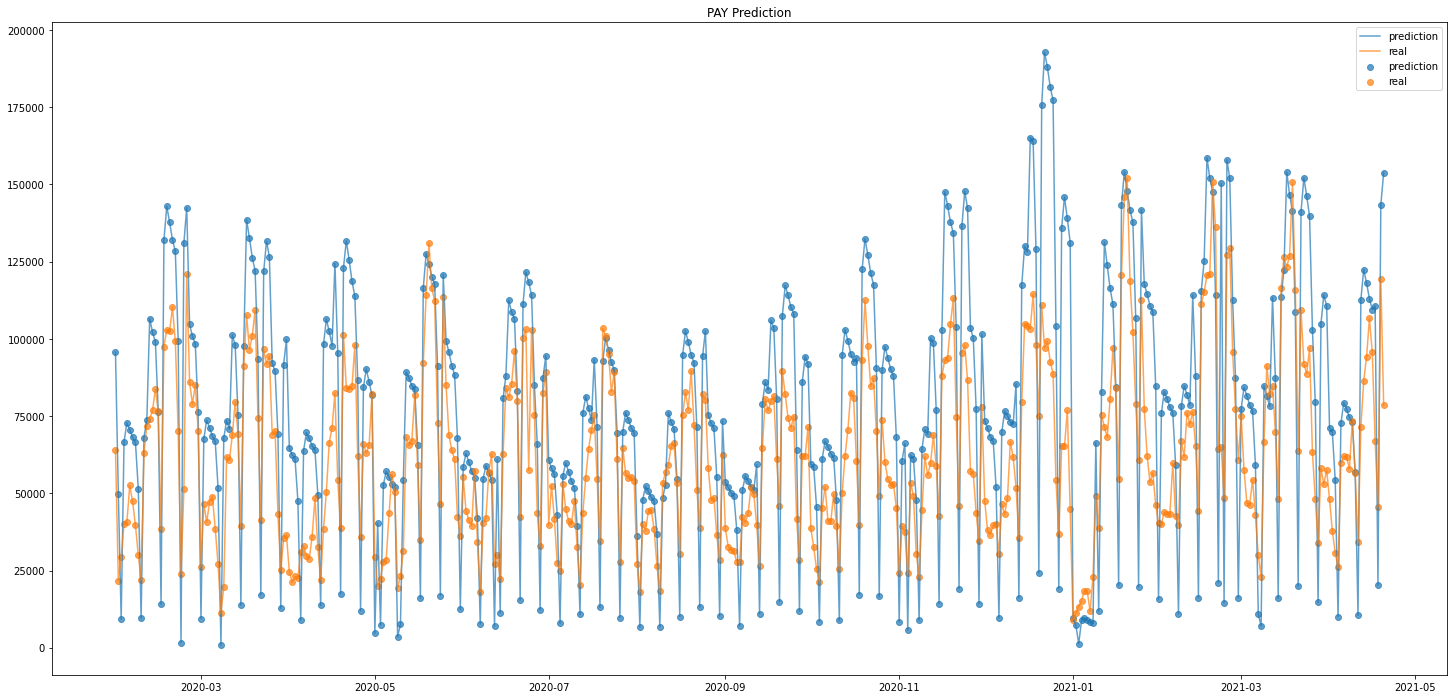

46.17741688005075

In [86]:
# Повторяем все действия на прологарифмированном ряде
train_data_pr_log = train_data_pr.copy()
train_data_pr_log.y = np.log(train_data_pr.y)

model_prop_log = Prophet(holidays=holiday,     
             changepoint_prior_scale = 0.001, 
             weekly_seasonality = True,       
             yearly_seasonality = True,       
             n_changepoints = 100             
            )

# Добавляем регрессоры, то есть указываем, какие дополнительные признаки влияют на прогноз
model_prop_log.add_regressor('sunday_date')
model_prop_log.add_regressor('bad_date')
model_prop_log.add_regressor('good_date')
model_prop_log.add_regressor('day_of_year')
model_prop_log.add_regressor('day_of_week')

# Обучаем модель
model_prop_log.fit(train_data_pr_log)

# Предсказываем и проверяем результат
forecast = model_prop_log.predict(future) 

# Выделяем из полного прогноза ряд предсказания
prediction_prop_log = forecast[forecast.ds>=START_DATE][['ds','yhat']]
prediction_prop_log = prediction_prop_log.rename(columns = {'ds': 'Date', 'yhat': 'PAY'})
prediction_prop_log = prediction_prop_log.set_index('Date')
prediction_prop_log.PAY = np.exp(prediction_prop_log.PAY)

# График и оценка
plot_prediction(df, prediction_prop_log)
mape(df[df.index>=START_DATE].PAY, prediction_prop_log.PAY)

Метрика ухудшилась, хотя к верхним пикам предсказания подтянулись. Но также предсказания излишне вытянулись в нижних значениях. В целом лограифмирование не помогло.

Ниже приводится код, при помощи которого выполнялся поиск оптимальных параметров для модели Prophet.

In [ ]:
# from sklearn.model_selection import ParameterGrid
# params_grid = {'seasonality_mode':('multiplicative','additive'),
#                'changepoint_prior_scale':[0.01,0.05,0.1],
#                'n_changepoints' : [50,100],
#                'weekly_seasonality' : [True,False],
#                'daily_seasonality' : [True,False],
#                'yearly_seasonality' : [True,False],
#               }
# grid = ParameterGrid(params_grid)
# cnt = 0
# for p in grid:
#     cnt = cnt+1

# print('Total Possible Models',cnt)

Total Possible Models 96

In [ ]:
# model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
# for p in grid:
#     print(p)
#     np.random.seed(0)
#     m7 = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
#                          n_changepoints = p['n_changepoints'],
#                          seasonality_mode = 'additive',
#                          weekly_seasonality= p['weekly_seasonality'],
#                          daily_seasonality = p['daily_seasonality'],
#                          yearly_seasonality = p['yearly_seasonality'],
#                          holidays=holiday, 
#                          interval_width=0.95)
    
#     m7.add_regressor('nfl_sunday')
#     m7.add_regressor('nfl_bad_date')
#     m7.add_regressor('nfl_good_date')
#     m7.fit(train_data_pr)
#     future7 = m7.make_future_dataframe(periods=PRED_LEN)
#     future7['nfl_sunday'] = future7['ds'].apply(nfl_sunday)
#     future7['nfl_bad_date'] = future7['ds'].apply(nfl_bad_date)
#     future7['nfl_good_date'] = future7['ds'].apply(nfl_good_date)
#     prophet_pred7 = m7.predict(future7)

#     temp7 = df3[df.index>=START_DATE]
#     temp7.y = prophet_pred7.yhat
#     temp7 = temp7.rename(columns = {'ds': 'Date', 'y': 'PAY'})
#     temp7 = temp7.set_index('Date')
    
#     MAPE = mape(df.loc[df.index>=START_DATE, "PAY"].values, temp7.PAY)
#     print('MAPE------------------------------------',MAPE)
#     model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

Лучший вариант:    
{'changepoint_prior_scale': 0.01, 'daily_seasonality': True, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': True}
MAPE------------------------------------ 24.862912001211704

По графику видно, что исходная модель (без логарифмирования) немного не догятивает в прогнозе до пиковых экстремумов. Поправим это вручную. Умножим прогноз на небольшой коэффициент для коррекции прогноза в области локальных экстремумов, которые Prophet считает выбросами.

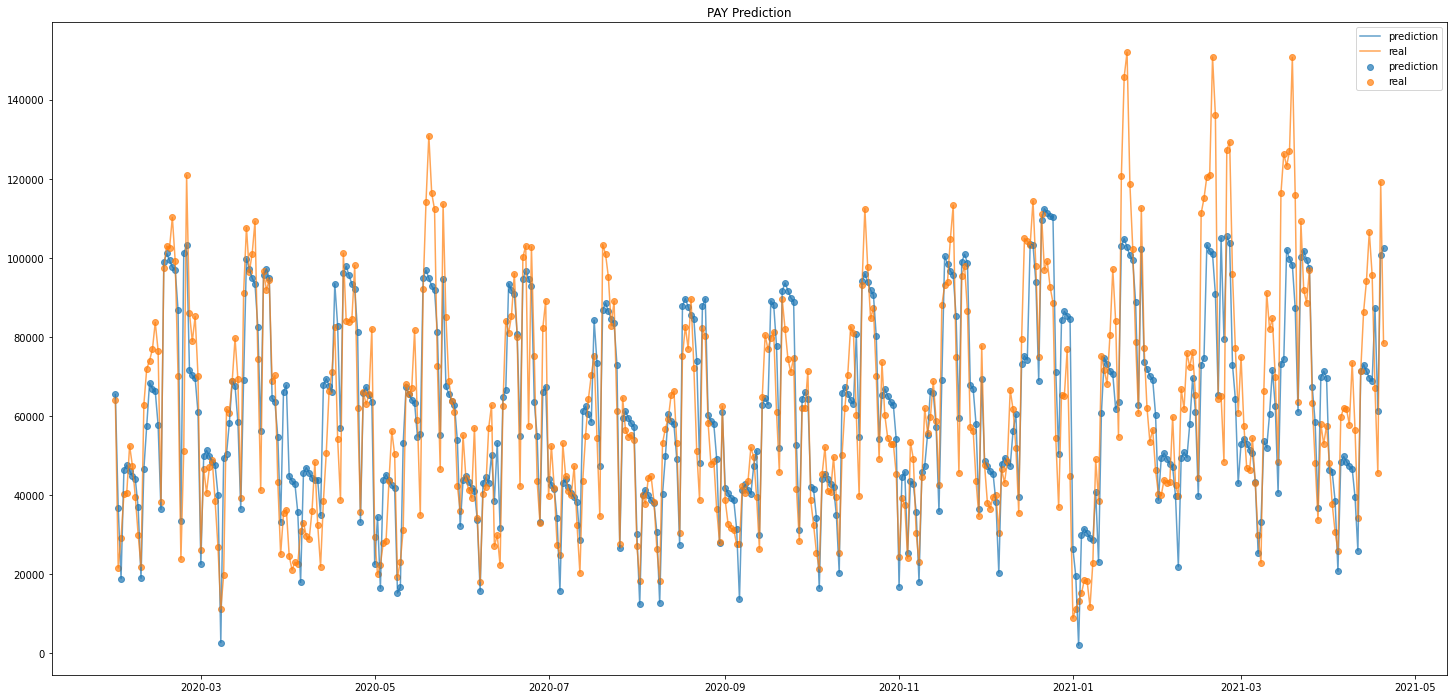

20.823035750424733

In [87]:
# Корректируем прогноз в экстремумах
prediction_prop_corr = prediction_prop.copy()
prediction_prop_corr['PAY'] = prediction_prop.apply(lambda row: \
                row['PAY']*1.2 if row.name.day>=17 and row.name.day<=25 else \
                row['PAY']/1.2 if row.name.day<=10 else \
                row['PAY'] , axis=1)

# График и оценка
plot_prediction(df, prediction_prop_corr)
mape(df[df.index>=START_DATE].PAY, prediction_prop_corr.PAY)

Скорректированный прогноз улучшил метрику.

In [ ]:
# prediction61['mPAY'] = prediction61.apply(lambda row: \
# #                 row['PAY']*1.1 if row['dt'].day>=17 and row['dt'].day<=25 else \
# #                 row['PAY']/1.2 if row['dt'].day<=10 else \
#                 row['PAY']*1.03+4000000 , axis=1)

# Ансамбль моделей

Теперь, после того как получили прогнозы при помощи моделей нескольких видов, соединим их в ансамбле. Сначала возьмём простое среднее по всем моделям, а затем из всех предсказаний составим регрессию и построим взвешенное среднее с учётом коэффициентов регрессии.

### Подготовка данных для ансамбля

Для быстроты работы загрузим модели, которые рассчитываются долго, и чей код обучения был взят в комментарии - это нейронные сети.  

In [88]:
# SARIMAX
# result_trend = SARIMAResults.load('result_trend.pickle')
# result_seasonal = SARIMAResults.load('result_seasonal.pickle')

# arima_pred_trend = result_trend.predict(start = PRED_LEN, end = len(df)-1, typ="levels")
# arima_pred_seasonal = results_seasonal.predict(start = PRED_LEN, end = len(df)-1, typ="levels")

# arima_full = arima_pred_trend + arima_pred_seasonal 
# arima_full = arima_full.dropna()

prediction_sarimax = pred_full
print(prediction_sarimax.head(2))
print(prediction_sarimax.tail(6))

2009-03-25    25371.931672
2009-03-26    23339.913376
Freq: D, dtype: float64
2021-04-15    75534.715308
2021-04-16    76382.454830
2021-04-17    71968.852504
2021-04-18    67349.111692
2021-04-19    81594.515276
2021-04-20    85801.175418
Freq: D, dtype: float64


In [89]:
# Prophet
# with open('serialized_model.json', 'r') as fin:
#     model_prop = model_from_json(json.load(fin))

# with open(pkl_path, 'rb') as f:
#     model_prop = pickle.load(f)
    
print(prediction_prop.head(2))
print(prediction_prop.tail(6))

                     PAY
Date                    
2020-01-31  65492.835707
2020-02-01  44282.992584
                     PAY
Date                    
2021-04-15  69731.646485
2021-04-16  68766.713746
2021-04-17  72810.633102
2021-04-18  51171.317443
2021-04-19  83996.894524
2021-04-20  85393.191518


In [90]:
# Загрузка моделей NN
model_conv1 = load_model('../input/payments-model/conv1.hdf5')
model_conv2 = load_model('../input/payments-model/conv2.hdf5')
model_rnn = load_model('../input/payments-model/rnn.hdf5')
model_lstm = load_model('../input/payments-model/lstm.hdf5')
model_bi_lstm = load_model('../input/payments-model/bi_lstm.hdf5')
model_sr1 = load_model('../input/payments-model/sr1.hdf5')
model_sr2 = load_model('../input/payments-model/sr2.hdf5')

# Списки моделей и предсказаний
modelsNN = [model_conv1,model_conv2,model_rnn,model_lstm,model_bi_lstm,model_sr1,model_sr2]
predictionsNN = []

# Предсказания
for i in range(len(modelsNN)):
    m = modelsNN[i]
    if i==3 or i==4:
        yhat = m.predict(test_x, batch_size=1)
    else:
        yhat = m.predict(test_x)
    temp = df_scal[-PRED_LEN+INPUT_LEN:]
    temp.PAY = yhat
    predictionsNN.append(pd.DataFrame(scaler.inverse_transform(temp), columns=df_scal.columns))

### Простое среднее предсказаний

In [91]:
# Датасет для aнсамбля
prediction = predictionsNN[0].copy()

# Суммируем предсказания нейронных сетей
for i in range(1,len(predictionsNN)):
    prediction = prediction + predictionsNN[i]
    
# Добавляем предсказания SARIMAX и Prophet
# prediction.PAY = prediction.PAY + prediction_sarimax[-PRED_LEN+INPUT_LEN:].reset_index().iloc[:,1].rename('PAY')
prediction.PAY = prediction.PAY + prediction_prop[-PRED_LEN+INPUT_LEN:].reset_index().iloc[:,1]

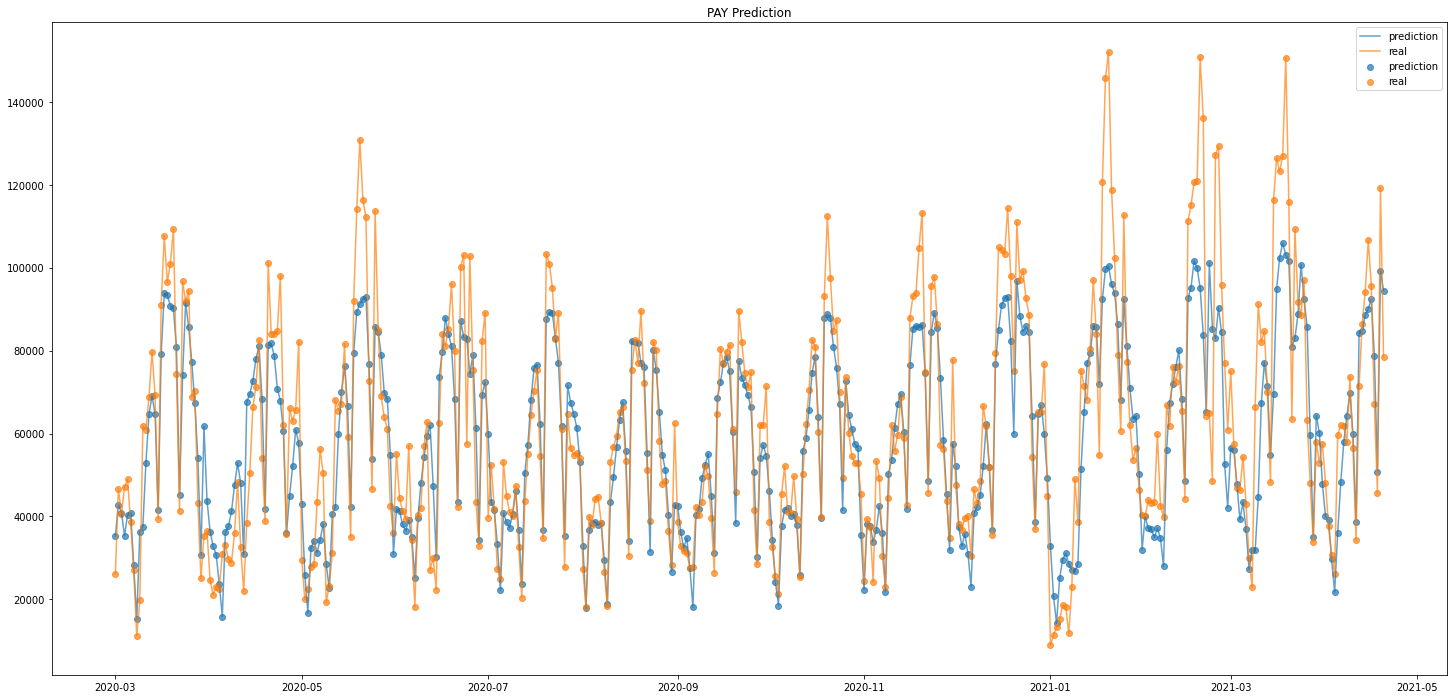

16.877660874268464

In [92]:
# Вычисляем среднее, строим график и проверяем оценку
prediction.PAY = prediction.PAY / (len(predictionsNN)+1)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction)
mape(df[-PRED_LEN+INPUT_LEN:].PAY, prediction.PAY)

mape:    
* для полного ансамбля всех моделей = 17.52
* для ансамбля только из нейронных сетей = 17.36    
* для ансамбля всех моделей без SARIMAX = 16.88

### Регрессия предсказаний

In [93]:
# Составим обучающие мета-данные для линейной регрессии
meta_train = np.hstack([
    np.array(predictionsNN[0].PAY).reshape(-1,1), 
    np.array(predictionsNN[1].PAY).reshape(-1,1),
    np.array(predictionsNN[2].PAY).reshape(-1,1),
    np.array(predictionsNN[3].PAY).reshape(-1,1),
    np.array(predictionsNN[4].PAY).reshape(-1,1),
    np.array(predictionsNN[5].PAY).reshape(-1,1),
    np.array(predictionsNN[6].PAY).reshape(-1,1),
#     np.array(prediction_sarimax[-PRED_LEN+INPUT_LEN:]).reshape(-1,1),
    np.array(prediction_prop[-PRED_LEN+INPUT_LEN:].PAY).reshape(-1,1)
])

y_meta_train = df[-PRED_LEN+INPUT_LEN:].PAY.values.reshape(-1,1)

In [94]:
# Мета-модель CatBoost
from catboost import CatBoostRegressor
meta_CatBt = CatBoostRegressor(iterations = 5000,
                          random_seed = 21,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
meta_CatBt.fit(meta_train, y_meta_train, verbose_eval=0)
coeff = meta_CatBt.feature_importances_
coeff = coeff/100
coeff

array([0.11628278, 0.08466846, 0.12683852, 0.07743247, 0.13885572,
       0.10315013, 0.13071674, 0.22205518])

Коэффициенты:    
[0.11628278, 0.08466846, 0.12683852, 0.07743247, 0.13885572, 0.10315013, 0.13071674, 0.22205518]

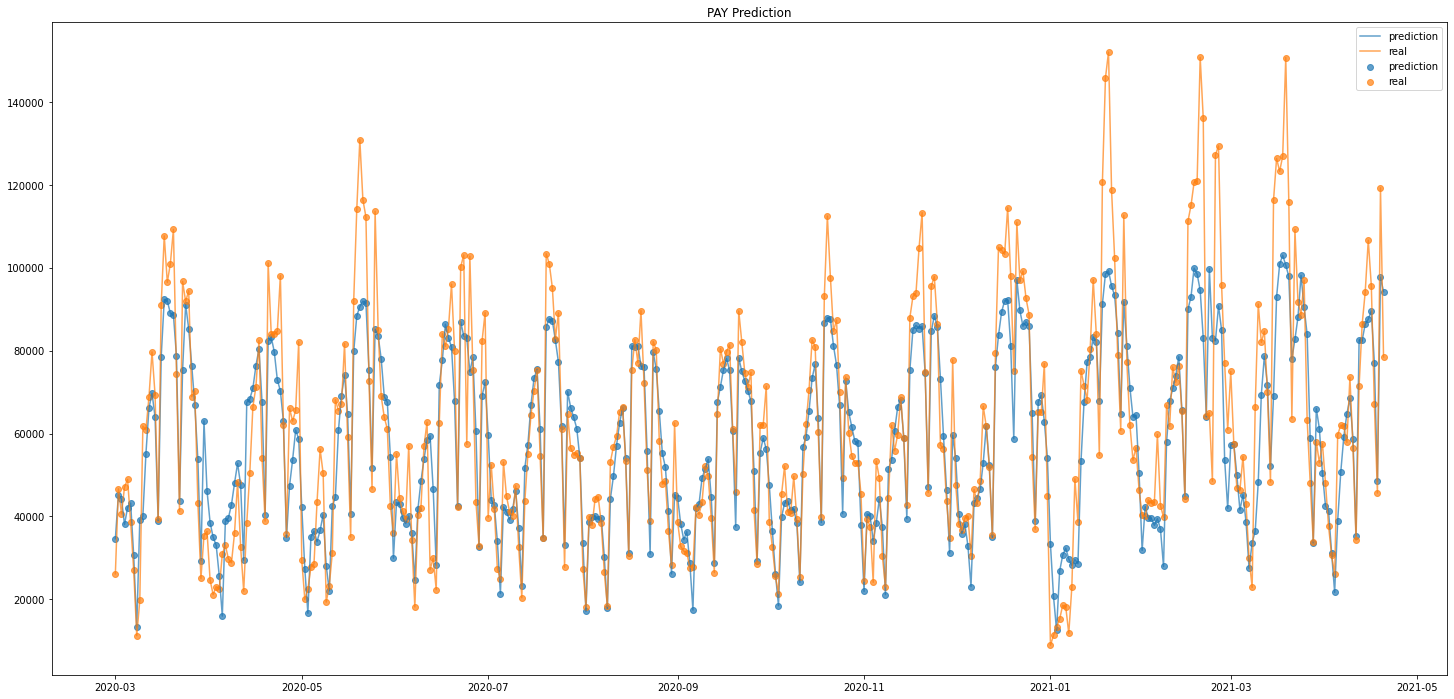

16.664642192567054

In [95]:
prediction['mean_PAY'] = (
    coeff[0]*predictionsNN[0].PAY + \
    coeff[1]*predictionsNN[1].PAY + \
    coeff[2]*predictionsNN[2].PAY + \
    coeff[3]*predictionsNN[3].PAY + \
    coeff[4]*predictionsNN[4].PAY + \
    coeff[5]*predictionsNN[5].PAY + \
    coeff[6]*predictionsNN[6].PAY + \
#     coeff[7]*prediction_sarimax[-PRED_LEN+INPUT_LEN:].reset_index().iloc[:,1].rename('PAY') + \
    coeff[7]*prediction_prop[-PRED_LEN+INPUT_LEN:].reset_index().iloc[:,1]
)

plot_prediction(df[-PRED_LEN+INPUT_LEN:], prediction['mean_PAY'])
mape(df[-PRED_LEN+INPUT_LEN:].PAY, prediction['mean_PAY'])

mape:    
* для полного ансамбля всех моделей = 16.97
* для ансамбля только из нейронных сетей = 16.91    
* для ансамбля всех моделей без SARIMAX = 16.66

# Предсказание на заданное количество дней

После того, как исследован ряд и подобраны модели, сделаем предсказание на будущее. Предсказание будет выполняться на N дней вперед от конца набора данных, который у нас имеется.     
Заново обучим модели на полном наборе данных и предскажем будущее. С учетом того, что модель SARIMAX даёт не слишком хорошие оценки и без неё метрика лучше, будем использовать ансамбль из моделей NN и Prophet.

### Подготовка данных

In [96]:
# Заново читаем и готовим данные
df = get_data()

# Количество дней, за которое надо предсказать
N = 60

# Коэффициенты регрессии = коэффициенты для средневзвешенного
coeff = [0.11628278, 0.08466846, 0.12683852, 0.07743247, 0.13885572, 0.10315013, 0.13071674, 0.22205518]

In [97]:
# Процедура, которая совершает предсказание для одного дня и добавляет предсказание в датасет
def predict_one_day(df,i=1):
    print('Step: ', i )
    
    # Добавляем новую строку с пустым значением, которое будем предсказывать
    df.loc[df.index[-1] + timedelta(days=1),'PAY'] = 0
    
    # Новый стартовый индекс прогноза
    START_DATE = df.index[-1]
    
    # Нормализуем
    scaler = MinMaxScaler()
    df_scal = scaler.fit_transform(df)
    df_scal = pd.DataFrame(df_scal, columns=df.columns)

    # Разделим на тренировочную и тестовую части
    test = df_scal[df.index>=START_DATE]
    train = df_scal[df.index<START_DATE]
    
    # Генерируем набор признаков из предыдущих значений для обучающей выборки
    train_x = []
    for i in range(INPUT_LEN, len(train)):
        train_x.append(train.iloc[i-INPUT_LEN:i])
    train_y = train.iloc[INPUT_LEN:]
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
    
    # Генерируем набор признаков из предыдущих значений для тестовой выборки
    test_x = []
    for i in range(len(df_scal)-1, len(df_scal)):
        test_x.append(df_scal.iloc[i-INPUT_LEN:i])
    test_x = np.array(test_x)
    test_y = [0]
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))
    
    # Предсказания разных моделей для одного дня
    predictions = []
    for i in range(len(modelsNN)):
        m = modelsNN[i]
        if i==3 or i==4:
            yhat = m.predict(test_x, batch_size=1)
        else:
            yhat = m.predict(test_x)
        temp = df_scal.iloc[-1].copy()
        temp.PAY = yhat
        temp_df = pd.DataFrame(temp)
        temp_df = temp_df.rename(columns = {temp_df.columns[0]: 'PAY'})
        predictions.append(scaler.inverse_transform(temp_df)[0][0])
    
    # Отдельно предсказываем с помощью Prophet
    train_data_pr = df[:-1].copy()
    train_data_pr = train_data_pr.reset_index()
    train_data_pr.columns = ['ds','y'] 

    model_prop = Prophet(holidays=holiday,         
                 changepoint_prior_scale = 0.001, 
                 weekly_seasonality = True,       
                 yearly_seasonality = True,       
                 n_changepoints = 100             
                )
    model_prop.add_regressor('sunday_date')
    model_prop.add_regressor('bad_date')
    model_prop.add_regressor('good_date')
    model_prop.add_regressor('day_of_year')
    model_prop.add_regressor('day_of_week')

    train_data_pr['day_of_year'] = train_data_pr['ds'].dt.dayofyear
    train_data_pr['day_of_week'] = train_data_pr['ds'].dt.day_of_week
    train_data_pr['sunday_date'] = train_data_pr['ds'].apply(sunday_date)
    train_data_pr['bad_date'] = train_data_pr['ds'].apply(bad_date)
    train_data_pr['good_date'] = train_data_pr['ds'].apply(good_date)

    model_prop.fit(train_data_pr)
    future = model_prop.make_future_dataframe(periods=1)

    future['sunday_date'] = future['ds'].apply(sunday_date)
    future['bad_date'] = future['ds'].apply(bad_date)
    future['good_date'] = future['ds'].apply(good_date)
    future['day_of_year'] = future['ds'].dt.dayofyear
    future['day_of_week'] = future['ds'].dt.day_of_week

    forecast = model_prop.predict(future)

    prediction_prop = forecast[forecast.ds>=START_DATE][['ds','yhat']]
    prediction_prop = prediction_prop.rename(columns = {'ds': 'Date', 'yhat': 'PAY'})
    prediction_prop = prediction_prop.set_index('Date')
    
    prediction_prop['PAY'] = prediction_prop.apply(lambda row: \
                row['PAY']*1.2 if row.name.day>=17 and row.name.day<=25 else \
                row['PAY'] , axis=1)
    
    predictions.append(prediction_prop.iloc[0,0])
    
    # Получаем среднее от всех предсказаний
    new_value = sum(predictions)/len(predictions)
    
    # Получаем средневзвешенное
#     new_value = \
#     coeff[0]*predictions[0] + \
#     coeff[1]*predictions[1] + \
#     coeff[2]*predictions[2] + \
#     coeff[3]*predictions[3] + \
#     coeff[4]*predictions[4] + \
#     coeff[5]*predictions[5] + \
#     coeff[6]*predictions[6] 
    
    # Корректируем срезанные выбросы
    curr_index = df.index[-1]
    if curr_index.day >= 17 and curr_index.day <= 25:
        print(curr_index, new_value)
        new_value *= 1.1
        print(curr_index, new_value)
    
    df.iloc[len(df)-1].PAY = new_value
    return df

### Прогнозирование

In [98]:
for i in range(1, N+1):
    df = predict_one_day(df,i)

Step:  1
2021-04-21 00:00:00 87808.88086582941
2021-04-21 00:00:00 96589.76895241237
Step:  2
2021-04-22 00:00:00 84593.79330435171
2021-04-22 00:00:00 93053.1726347869
Step:  3
2021-04-23 00:00:00 82447.0825630149
2021-04-23 00:00:00 90691.7908193164
Step:  4
2021-04-24 00:00:00 68690.91147984489
2021-04-24 00:00:00 75560.00262782938
Step:  5
2021-04-25 00:00:00 46741.69748148752
2021-04-25 00:00:00 51415.86722963628
Step:  6
Step:  7
Step:  8
Step:  9
Step:  10
Step:  11
Step:  12
Step:  13
Step:  14
Step:  15
Step:  16
Step:  17
Step:  18
Step:  19
Step:  20
Step:  21
Step:  22
Step:  23
Step:  24
Step:  25
Step:  26
Step:  27
2021-05-17 00:00:00 91823.94156431562
2021-05-17 00:00:00 101006.3357207472
Step:  28
2021-05-18 00:00:00 90210.07823683498
2021-05-18 00:00:00 99231.08606051849
Step:  29
2021-05-19 00:00:00 92896.43045887277
2021-05-19 00:00:00 102186.07350476005
Step:  30
2021-05-20 00:00:00 89388.83036427388
2021-05-20 00:00:00 98327.71340070126
Step:  31
2021-05-21 00:00:

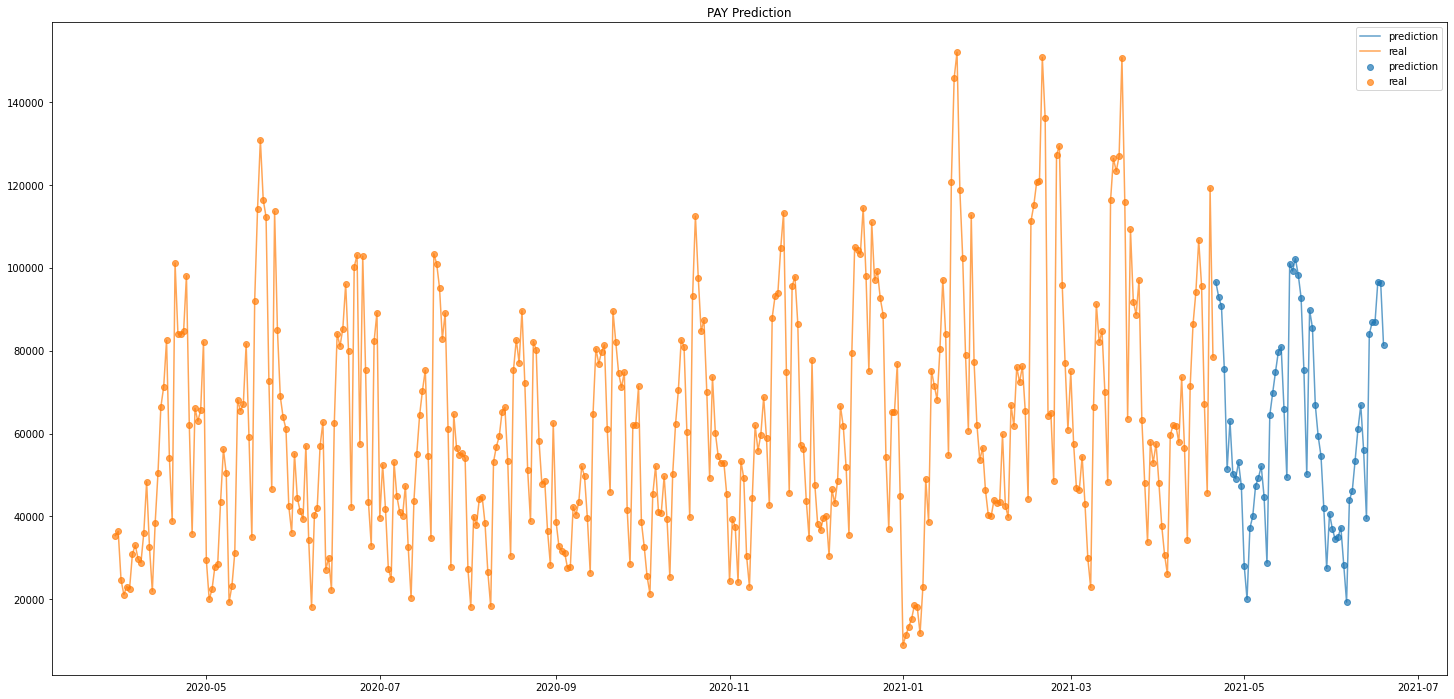

In [99]:
# Построим график исходных данных и график прогноза на будущее
start_plot = '2020-03-30'

plt.figure(figsize=(25, 12))
plt.plot(df.index[(df.index>LAST_REAL) ], 
         df.loc[(df.index>LAST_REAL), PRED_COLUMN], label="prediction", alpha=.7)
plt.plot(df.index[(df.index>=start_plot) & (df.index<=LAST_REAL)], 
         df.loc[(df.index>=start_plot) & (df.index<=LAST_REAL), PRED_COLUMN], label="real", alpha=.7)
plt.scatter(df.index[(df.index>LAST_REAL)], 
         df.loc[(df.index>LAST_REAL) , PRED_COLUMN], label="prediction", alpha=.7)
plt.scatter(df.index[(df.index>=start_plot) & (df.index<=LAST_REAL)], 
         df.loc[(df.index>=start_plot) & (df.index<=LAST_REAL), PRED_COLUMN], label="real", alpha=.7)
plt.legend() 
plt.title(PRED_COLUMN + " Prediction")
plt.show() 

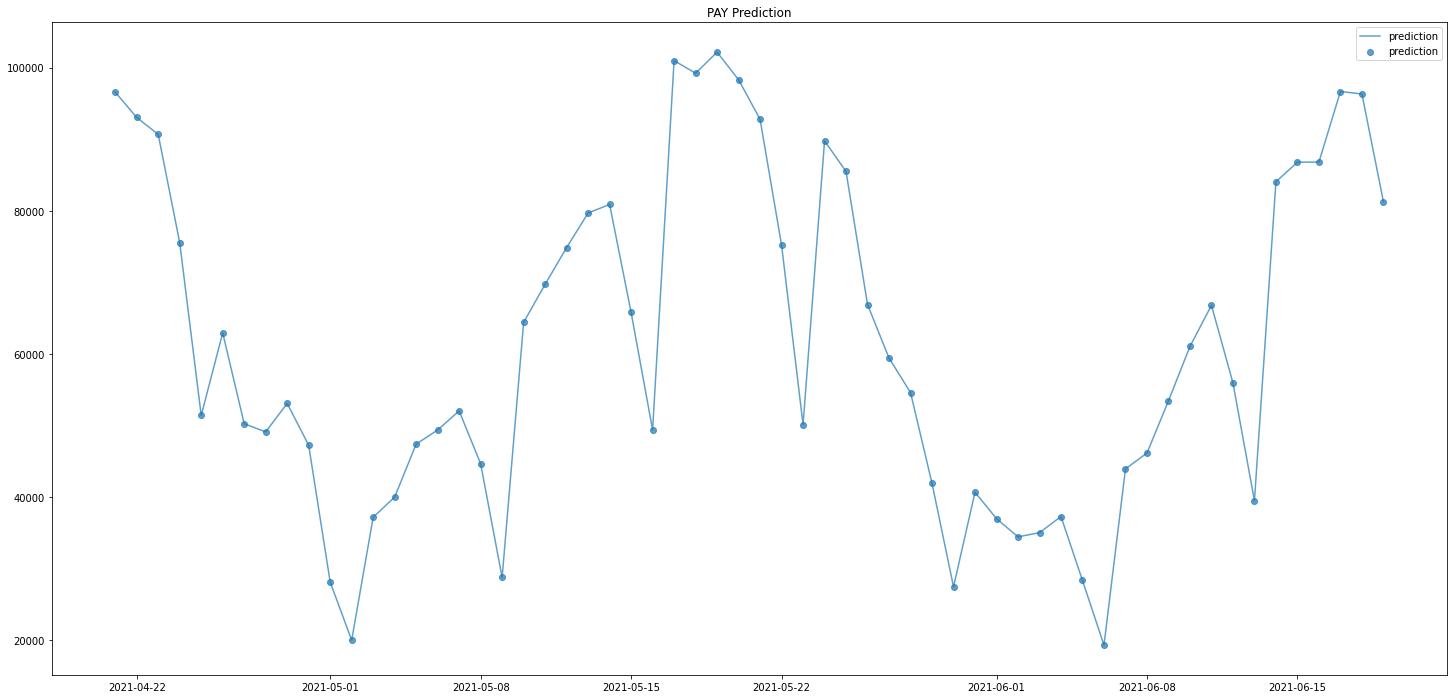

In [100]:
# Построим график только прогноза
plt.figure(figsize=(25, 12))
plt.plot(df.index[(df.index>LAST_REAL) ], 
         df.loc[(df.index>LAST_REAL), PRED_COLUMN], label="prediction", alpha=.7)
plt.scatter(df.index[(df.index>LAST_REAL)], 
         df.loc[(df.index>LAST_REAL) , PRED_COLUMN], label="prediction", alpha=.7)
plt.legend() 
plt.title(PRED_COLUMN + " Prediction")
plt.show() 

По графику видно, что прогноз учитывает дни недели и недели в месяце.

### Сохранение результата

In [101]:
df_res = df[df.index > LAST_REAL]
df_res.to_csv('forecast_' + str(N) + '.csv')

# Заключение

В данной работе рассматривались разные спoсобы предсказания оплаты, ежедневно поступающей от общего объёма должников энергосбытовой компании.      

**Работа состояла из нескольких этапов:**    
1) Чтение и преобразование данных;     
2) Визуализация временного ряда и его сезонных компонентов;    
3) Оценка стационарности ряда и возможности применения тех или иных методов моделирования;    
4) Построение и проверка модели прогнозирования ML-методом SARIMAX;    
5) Построение и проверка прогнозирования нейронными сетями разных архитектур;     
6) Построение и проверка специальной модели Prophet от Facebook для прогнозирования временных рядов с выраженной сезонностью;   
7) Построение и проверка ансамбля из разных моделей;   
8) Выдача прогноза оплаты на заданное количество дней.

**Выводы по применению моделей:**     
1) Временной ряд нестационерен, имеет сложную структуру и плохо прогнозируется классическим метотодом ARIMA, даже в его разновидности SARIMAX, учитывающей сезонность.     
2) Разложение ряда на тренд, сезонность, остаток и последующее прогнозирование методом SARIMAX отдельно каждой компоненты дают существенно лучший результат. Возможно, дополнительное разложение тренда и остатка аналогичным образом дали бы ещё более точную оценку.    
3) Применение нейронных сетей даёт метрику лучше, чем Prophet и SARIMAX.     
4) Среди разных опробованных видов нейронных сетей лучше всего себя зарекомендовала смешанная архитектура: свёрточные слои + рекуррентные, то есть архитектура вида CNN + LSTM.      
5) Модель Prophet неплохо прогнозирует при условии, что нет выбросов. Выбросы данная модель игнорирует и дает плохой прогноз в точках локальных экстремумов.      
6) Применение ансамбля из моделей NN + Prophet существенно улучшает метрику прогноза.     
7) В целом из-за сложности временного ряда очень точные прогнозы (mape<10%) получить не удается. Наилучшая ошбка прогнозирования составляет примерно 17%.